# Fish Image Classification Using Convolutional Neural Networks (CNN)

---

## Project Overview

This notebook presents a complete end-to-end image classification pipeline for classifying fish species using Convolutional Neural Networks (CNN). The dataset contains images of 31 different fish species, and our goal is to build robust deep learning models that can accurately identify the fish species from images.

### Objectives:
1. **Data Exploration & Preprocessing**: Understand the dataset structure, visualize samples, and prepare data for training
2. **Data Augmentation**: Apply various augmentation techniques to improve model generalization
3. **CNN from Scratch**: Design and train a custom CNN architecture
4. **Transfer Learning**: Leverage pre-trained models (MobileNetV2) for improved performance
5. **Model Evaluation**: Compare models using various metrics and visualizations
6. **Interpretation**: Understand what the CNN learns through feature map visualization

### Why CNN for Image Classification?
Convolutional Neural Networks are particularly effective for image classification tasks because:
- They automatically learn hierarchical features from raw pixel data
- Convolutional layers detect spatial patterns (edges, textures, shapes)
- Pooling layers provide translation invariance
- They require fewer parameters than fully connected networks for image data

---

## 2. Import Libraries

- **os, glob**: File system operations and path handling
- **numpy**: Numerical computations and array operations
- **pandas**: Data manipulation and analysis
- **matplotlib, seaborn**: Data visualization
- **tensorflow/keras**: Deep learning framework for building and training CNN models
- **sklearn**: Machine learning utilities for evaluation metrics

In [17]:
# System and file operations
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                      Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model

# Evaluation metrics
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("Libraries imported successfully!")

TensorFlow Version: 2.20.0
GPU Available: []
Libraries imported successfully!


## 3. Dataset Loading & Exploration


In [18]:
# Define dataset paths
# Update this path according to your directory structure
BASE_DIR = 'FishImgDataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Verify directories exist
print("Directory Structure Verification:")
print(f"Training directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(VAL_DIR)}")
print(f"Test directory exists: {os.path.exists(TEST_DIR)}")

# Get class names from training directory
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)

print(f"\nDataset Overview:")
print(f"Number of classes: {num_classes}")
print(f"\nFish Species (Classes):")
for i, name in enumerate(class_names, 1):
    print(f"  {i:2d}. {name}")

Directory Structure Verification:
Training directory exists: True
Validation directory exists: True
Test directory exists: True

Dataset Overview:
Number of classes: 31

Fish Species (Classes):
   1. Bangus
   2. Big Head Carp
   3. Black Spotted Barb
   4. Catfish
   5. Climbing Perch
   6. Fourfinger Threadfin
   7. Freshwater Eel
   8. Glass Perchlet
   9. Goby
  10. Gold Fish
  11. Gourami
  12. Grass Carp
  13. Green Spotted Puffer
  14. Indian Carp
  15. Indo-Pacific Tarpon
  16. Jaguar Gapote
  17. Janitor Fish
  18. Knifefish
  19. Long-Snouted Pipefish
  20. Mosquito Fish
  21. Mudfish
  22. Mullet
  23. Pangasius
  24. Perch
  25. Scat Fish
  26. Silver Barb
  27. Silver Carp
  28. Silver Perch
  29. Snakehead
  30. Tenpounder
  31. Tilapia


In [19]:
# Function to count images in each directory
def count_images_per_class(directory):
    """Count number of images in each class folder"""
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count image files
            image_count = len([f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            class_counts[class_name] = image_count
    return class_counts

# Count images in each split
train_counts = count_images_per_class(TRAIN_DIR)
val_counts = count_images_per_class(VAL_DIR)
test_counts = count_images_per_class(TEST_DIR)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Validation': list(val_counts.values()),
    'Test': list(test_counts.values())
})
summary_df['Total'] = summary_df['Train'] + summary_df['Validation'] + summary_df['Test']
summary_df = summary_df.sort_values('Class').reset_index(drop=True)

# Display summary
print("Image Distribution Across Splits:\n")
print(summary_df.to_string(index=False))
print(f"\n{'='*60}")
print(f"Total Training Images: {summary_df['Train'].sum()}")
print(f"Total Validation Images: {summary_df['Validation'].sum()}")
print(f"Total Test Images: {summary_df['Test'].sum()}")
print(f"Total Images in Dataset: {summary_df['Total'].sum()}")

Image Distribution Across Splits:

                Class  Train  Validation  Test  Total
               Bangus    171          52    34    257
        Big Head Carp    201          63    43    307
   Black Spotted Barb    200          63    40    303
              Catfish    314          97    62    473
       Climbing Perch    152          48    30    230
 Fourfinger Threadfin    192          60    38    290
       Freshwater Eel    273          84    55    412
       Glass Perchlet    399         124    77    600
                 Goby    607         189   124    920
            Gold Fish    206          65    41    312
              Gourami    312          97    63    472
           Grass Carp   1222         378   238   1838
 Green Spotted Puffer    110          34    22    166
          Indian Carp    262          81    53    396
  Indo-Pacific Tarpon    186          57    39    282
        Jaguar Gapote    229          72    44    345
         Janitor Fish    286          89    58 

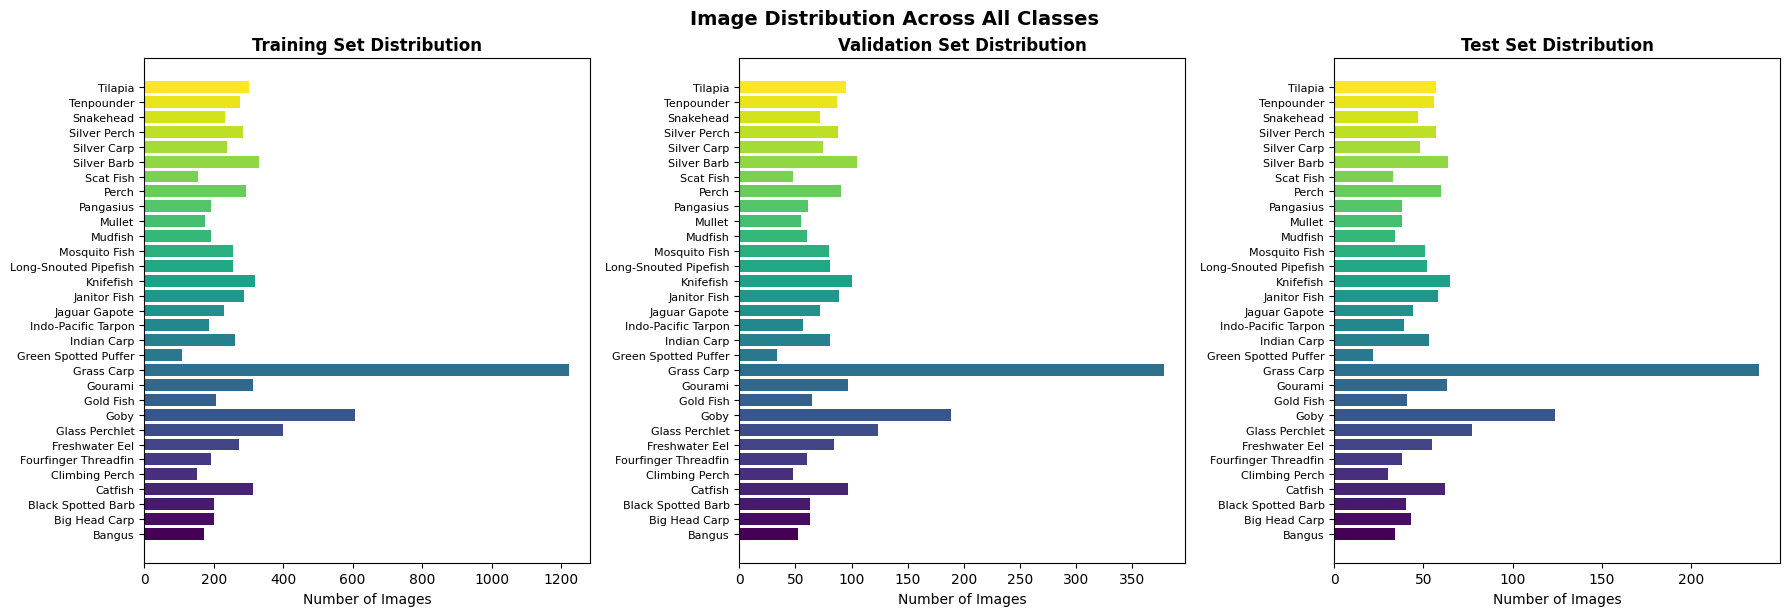

In [20]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Training set distribution
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(train_counts)))
bars1 = ax1.barh(list(train_counts.keys()), list(train_counts.values()), color=colors)
ax1.set_xlabel('Number of Images')
ax1.set_title('Training Set Distribution', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelsize=8)

# Validation set distribution
ax2 = axes[1]
bars2 = ax2.barh(list(val_counts.keys()), list(val_counts.values()), color=colors)
ax2.set_xlabel('Number of Images')
ax2.set_title('Validation Set Distribution', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelsize=8)

# Test set distribution
ax3 = axes[2]
bars3 = ax3.barh(list(test_counts.keys()), list(test_counts.values()), color=colors)
ax3.set_xlabel('Number of Images')
ax3.set_title('Test Set Distribution', fontsize=12, fontweight='bold')
ax3.tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.suptitle('Image Distribution Across All Classes', fontsize=14, fontweight='bold', y=1.02)
plt.show()

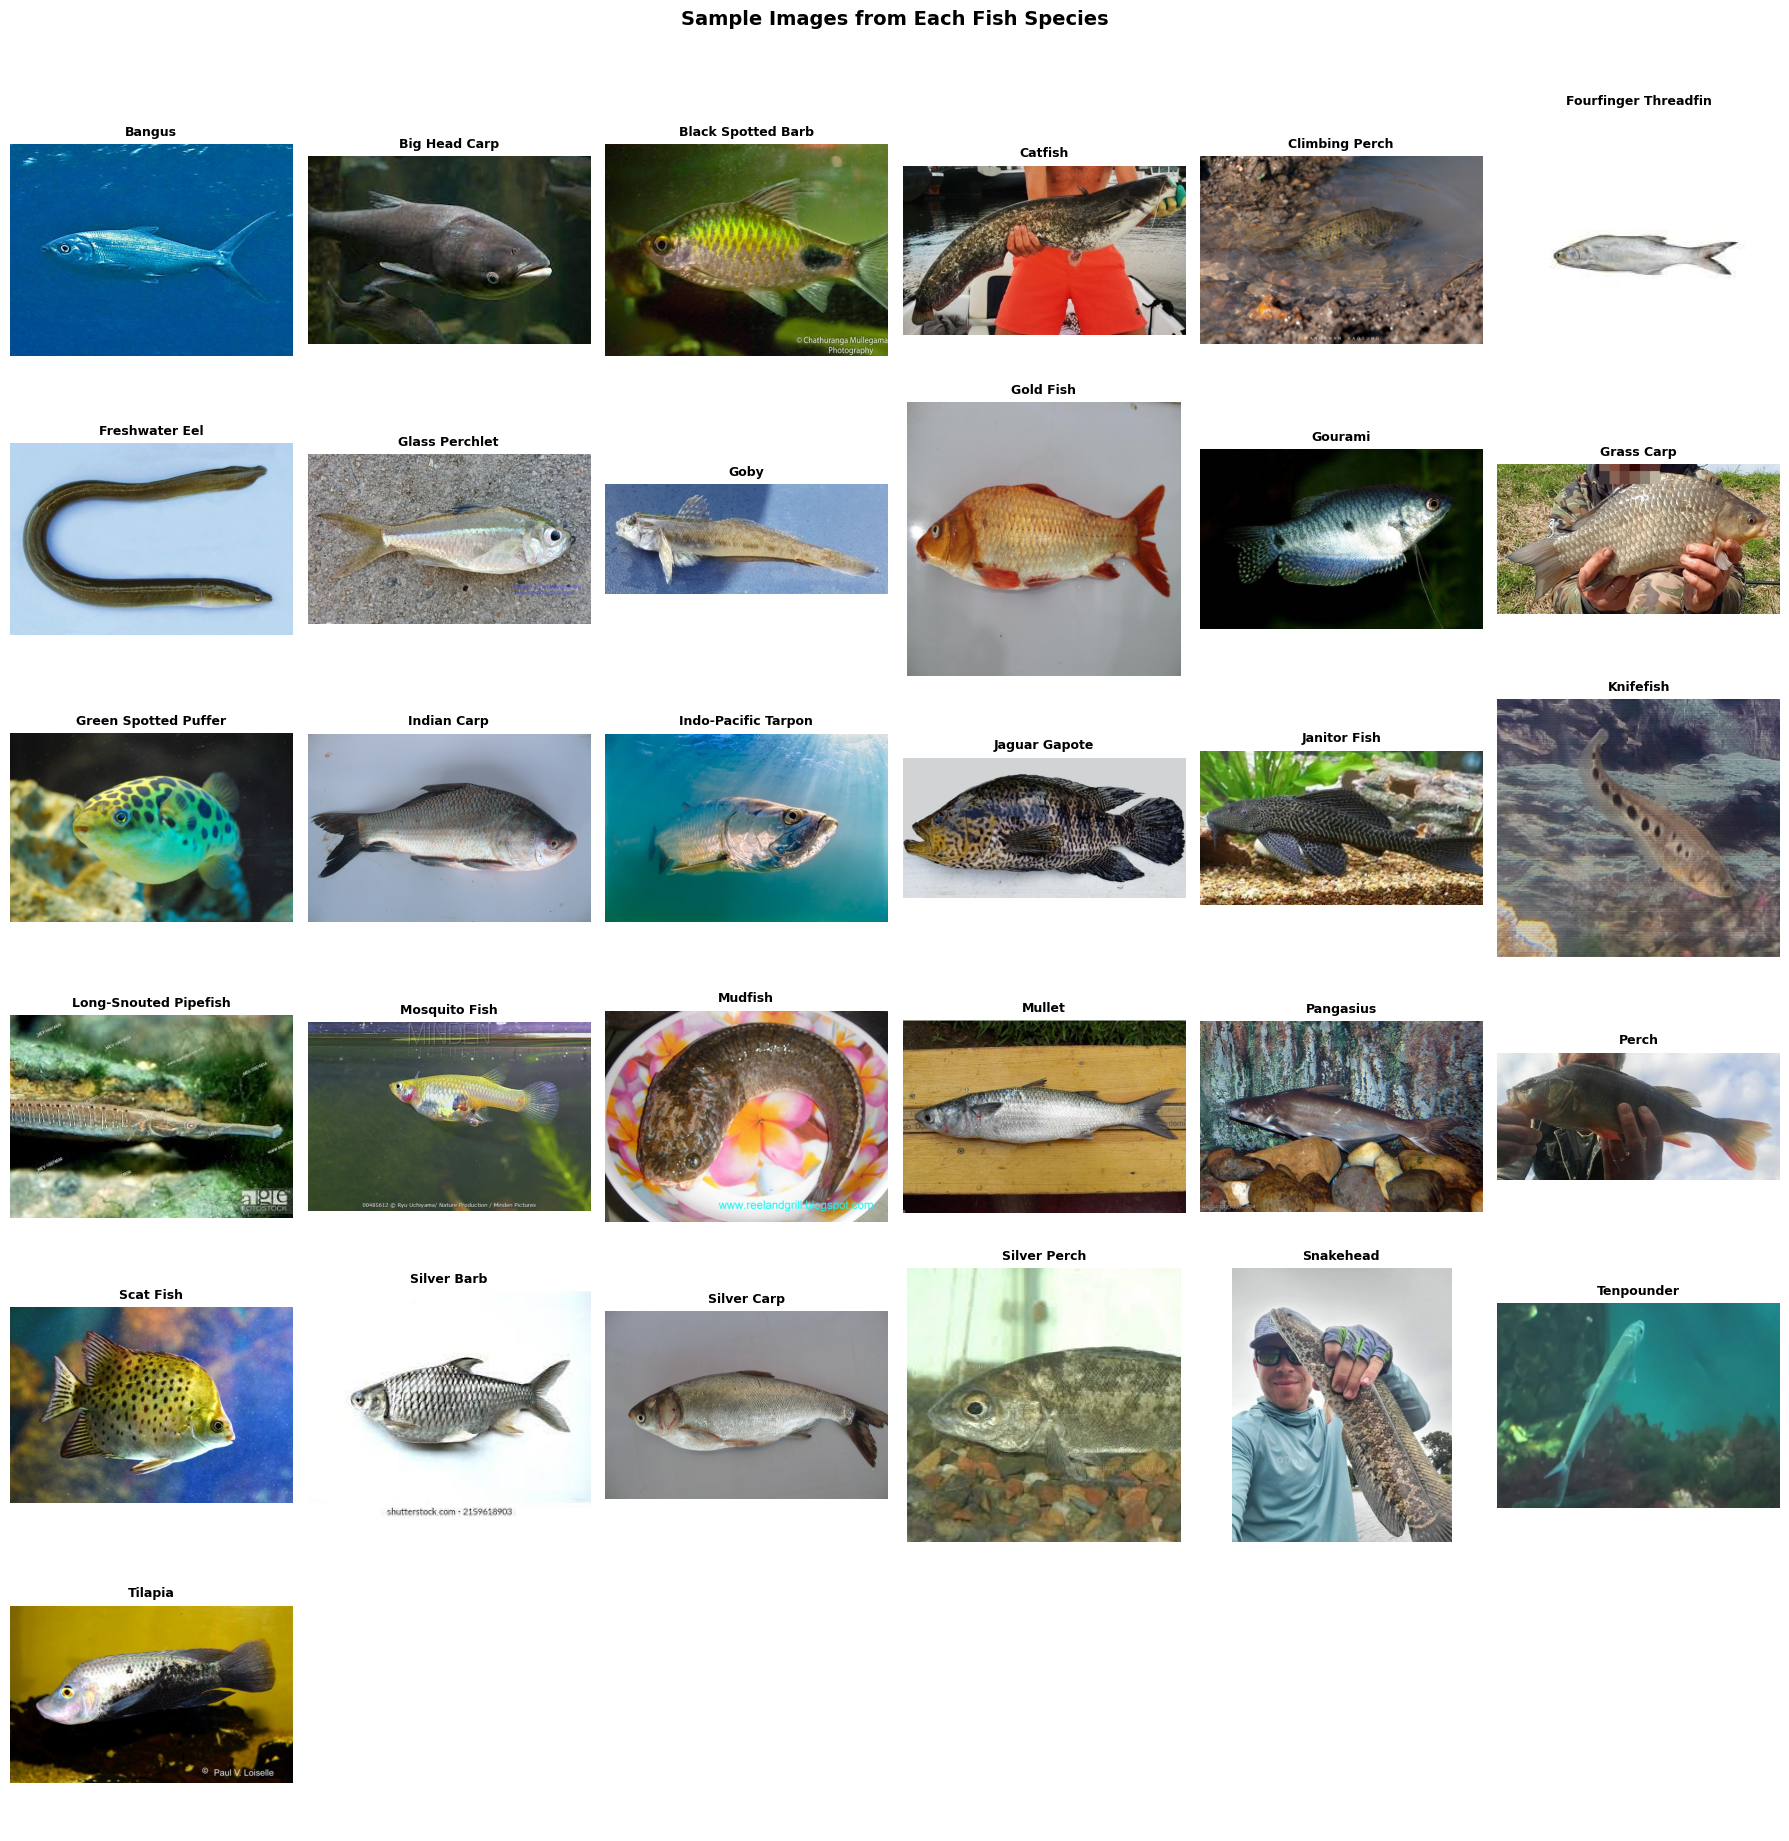

In [21]:
# Visualize sample images from each class
def display_sample_images(directory, class_names, samples_per_class=1):
    """Display sample images from each class"""
    n_classes = len(class_names)
    n_cols = 6
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3*n_rows))
    axes = axes.flatten()
    
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)
        if images:
            img_path = os.path.join(class_path, images[0])
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(class_name, fontsize=9, fontweight='bold')
            axes[idx].axis('off')
    
    # Hide empty subplots
    for idx in range(len(class_names), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Sample Images from Each Fish Species', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(TRAIN_DIR, class_names)

Image Dimension Statistics:
Width  - Min: 167, Max: 5184, Mean: 963.7
Height - Min: 100, Max: 3456, Mean: 634.3


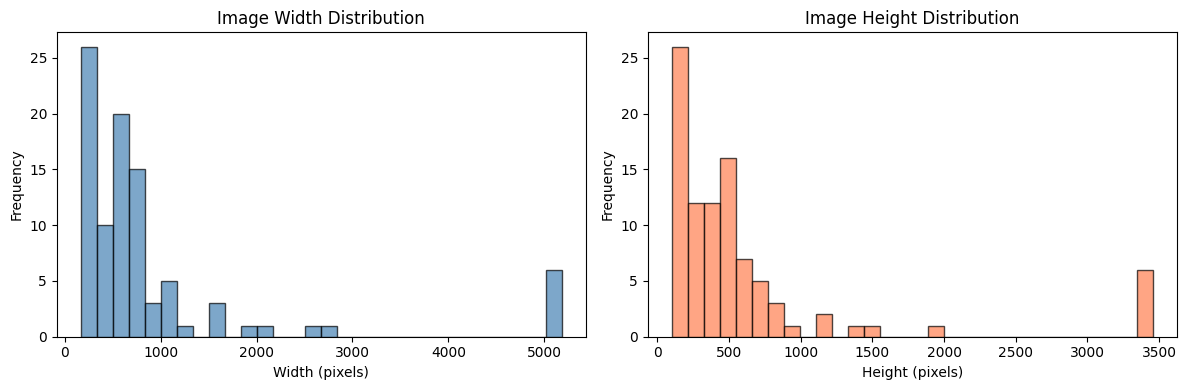

In [22]:
# Analyze image properties (size distribution)
def analyze_image_properties(directory, sample_size=100):
    """Analyze image dimensions in the dataset"""
    widths = []
    heights = []
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:sample_size // len(os.listdir(directory))]
            for img_name in images:
                try:
                    img_path = os.path.join(class_path, img_name)
                    with Image.open(img_path) as img:
                        widths.append(img.size[0])
                        heights.append(img.size[1])
                except:
                    continue
    
    return widths, heights

widths, heights = analyze_image_properties(TRAIN_DIR)

print("Image Dimension Statistics:")
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")

# Plot dimension distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(widths, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')

axes[1].hist(heights, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing


In [23]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

print(f"Image Configuration:")
print(f"  - Image Size: {IMG_SIZE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Input Shape: {INPUT_SHAPE}")
print(f"  - Number of Classes: {num_classes}")

Image Configuration:
  - Image Size: (224, 224)
  - Batch Size: 32
  - Input Shape: (224, 224, 3)
  - Number of Classes: 31


In [24]:
# Create data generators for validation and test sets (no augmentation)
# Only rescale pixel values to [0, 1]

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nData generators created successfully!")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.

Data generators created successfully!
Validation samples: 2751
Test samples: 1760


## 5. Data Augmentation


In [25]:
# Create training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values
    rotation_range=20,                  # Random rotation +/-20 degrees
    width_shift_range=0.2,              # Random horizontal shift
    height_shift_range=0.2,             # Random vertical shift
    shear_range=0.2,                    # Shear transformation
    zoom_range=0.2,                     # Random zoom
    horizontal_flip=True,               # Random horizontal flip
    brightness_range=[0.8, 1.2],        # Random brightness adjustment
    fill_mode='nearest'                 # Fill mode for new pixels
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print(f"Training generator created with augmentation!")
print(f"Training samples: {train_generator.samples}")

Found 8801 images belonging to 31 classes.
Training generator created with augmentation!
Training samples: 8801


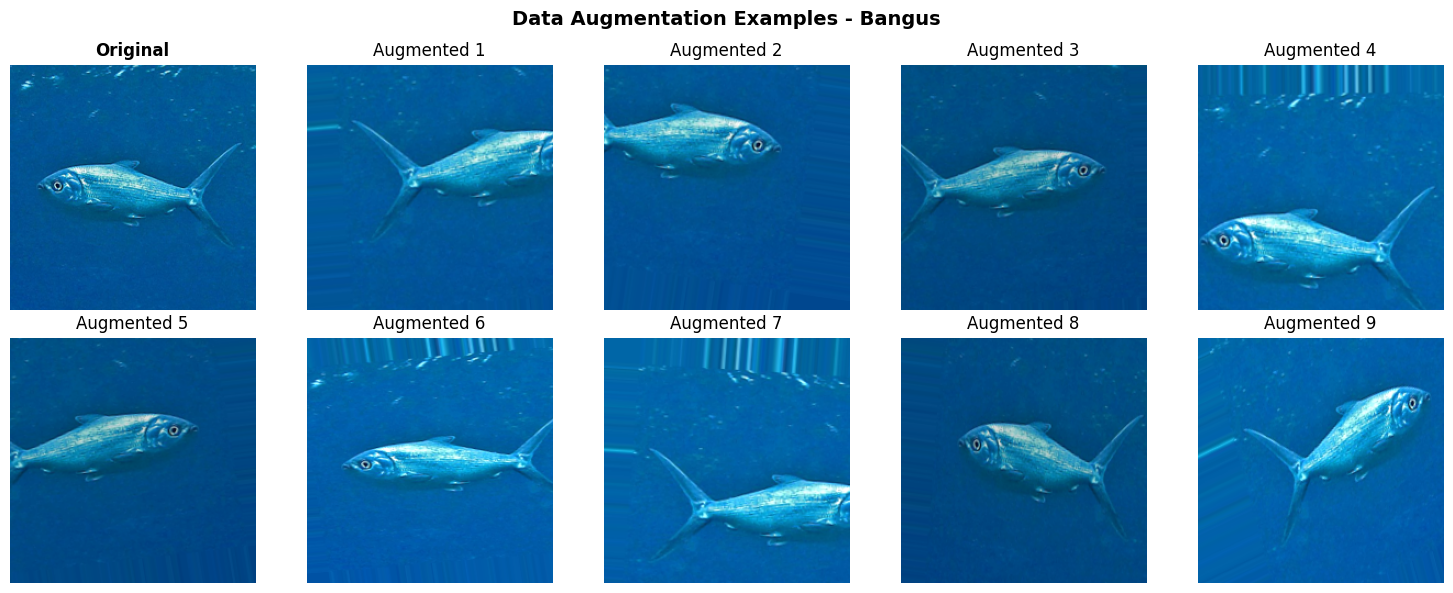

In [26]:
# Visualize augmented images
def visualize_augmentation(generator, class_name):
    """Visualize original and augmented versions of an image"""
    # Get a sample image
    class_path = os.path.join(TRAIN_DIR, class_name)
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)
    
    # Load original image
    original_img = Image.open(img_path)
    original_img = original_img.resize(IMG_SIZE)
    img_array = np.array(original_img)
    img_array = img_array.reshape((1,) + img_array.shape)
    
    # Create augmentation generator for this image
    aug_gen = train_datagen.flow(img_array, batch_size=1)
    
    # Plot original and augmented versions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Augmented versions
    for i in range(9):
        row = (i + 1) // 5
        col = (i + 1) % 5
        augmented_img = next(aug_gen)[0]
        axes[row, col].imshow(augmented_img)
        axes[row, col].set_title(f'Augmented {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle(f'Data Augmentation Examples - {class_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize augmentation for a sample class
visualize_augmentation(train_datagen, class_names[0])

## 6. Handling Class Imbalance


Class Indices Mapping:
  0: Bangus
  1: Big Head Carp
  2: Black Spotted Barb
  3: Catfish
  4: Climbing Perch
  5: Fourfinger Threadfin
  6: Freshwater Eel
  7: Glass Perchlet
  8: Goby
  9: Gold Fish
  10: Gourami
  11: Grass Carp
  12: Green Spotted Puffer
  13: Indian Carp
  14: Indo-Pacific Tarpon
  15: Jaguar Gapote
  16: Janitor Fish
  17: Knifefish
  18: Long-Snouted Pipefish
  19: Mosquito Fish
  20: Mudfish
  21: Mullet
  22: Pangasius
  23: Perch
  24: Scat Fish
  25: Silver Barb
  26: Silver Carp
  27: Silver Perch
  28: Snakehead
  29: Tenpounder
  30: Tilapia

Training Set Class Distribution:
  Min samples: 110
  Max samples: 1222
  Imbalance ratio: 11.11:1


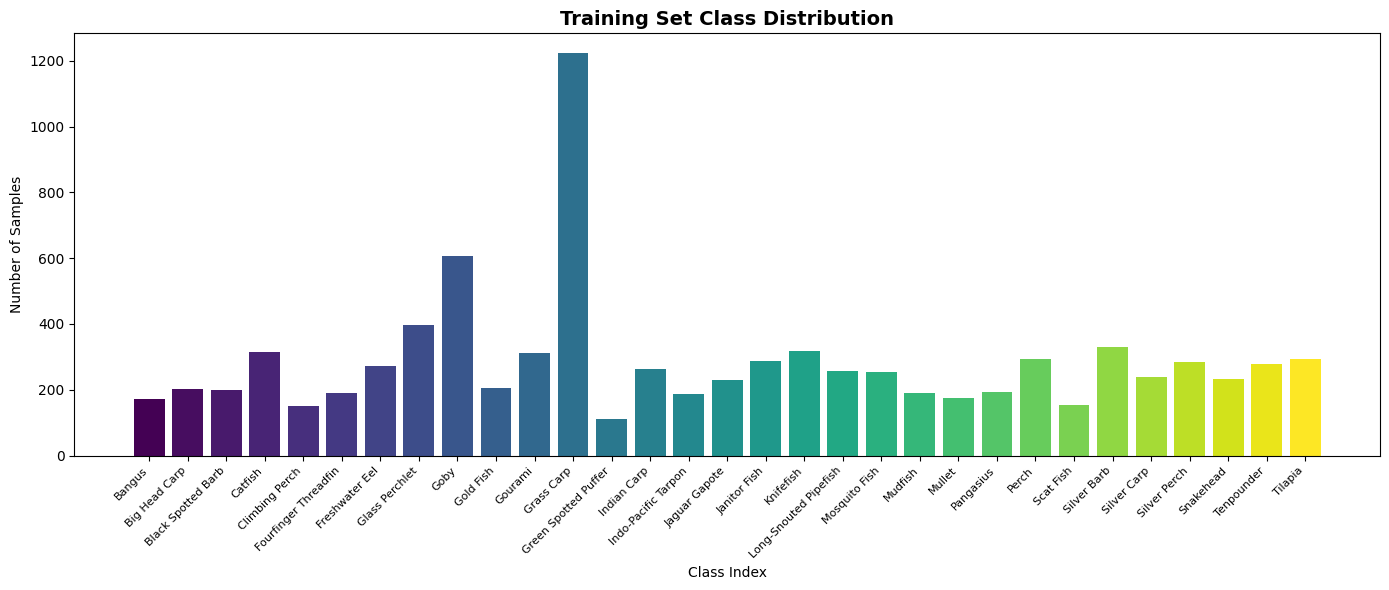

In [27]:
# Analyze class distribution
from sklearn.utils.class_weight import compute_class_weight

# Get class indices
class_indices = train_generator.class_indices
print("Class Indices Mapping:")
for class_name, idx in sorted(class_indices.items(), key=lambda x: x[1]):
    print(f"  {idx}: {class_name}")

# Get training labels
train_labels = train_generator.classes

# Analyze distribution
unique, counts = np.unique(train_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

print(f"\nTraining Set Class Distribution:")
print(f"  Min samples: {min(counts)}")
print(f"  Max samples: {max(counts)}")
print(f"  Imbalance ratio: {max(counts)/min(counts):.2f}:1")

# Visualize class distribution
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(counts)), counts, color=plt.cm.viridis(np.linspace(0, 1, len(counts))))
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(len(counts)), [list(class_indices.keys())[i] for i in range(len(counts))], 
           rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

Computed Class Weights:
--------------------------------------------------
  Class  0 (Bangus              ): 1.6603
  Class  1 (Big Head Carp       ): 1.4125
  Class  2 (Black Spotted Barb  ): 1.4195
  Class  3 (Catfish             ): 0.9042
  Class  4 (Climbing Perch      ): 1.8678
  Class  5 (Fourfinger Threadfin): 1.4864
  Class  6 (Freshwater Eel      ): 1.0476
  Class  7 (Glass Perchlet      ): 0.7151
  Class  8 (Goby                ): 0.4677
  Class  9 (Gold Fish           ): 1.3782
  Class 10 (Gourami             ): 0.9129
  Class 11 (Grass Carp          ): 0.2323
  Class 12 (Green Spotted Puffer): 2.5809
  Class 13 (Indian Carp         ): 1.0836
  Class 14 (Indo-Pacific Tarpon ): 1.5264
  Class 15 (Jaguar Gapote       ): 1.2398
  Class 16 (Janitor Fish        ): 0.9927
  Class 17 (Knifefish           ): 0.8900
  Class 18 (Long-Snouted Pipefis): 1.1090
  Class 19 (Mosquito Fish       ): 1.1177
  Class 20 (Mudfish             ): 1.5021
  Class 21 (Mullet              ): 1.6316
 

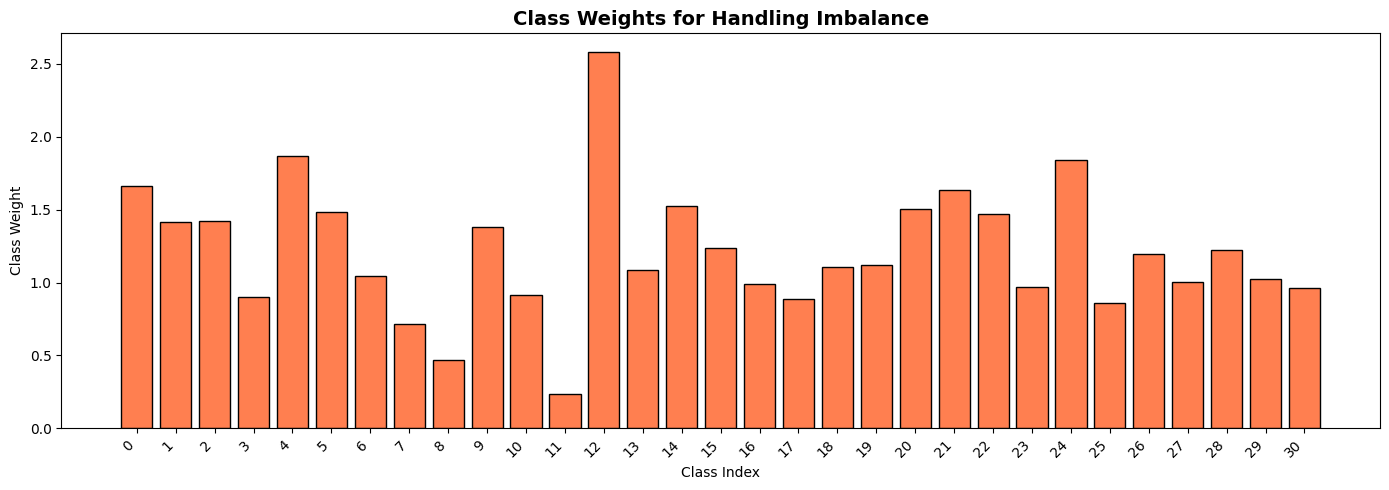


Class weights computed successfully!


In [28]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to dictionary format for Keras
class_weight_dict = dict(enumerate(class_weights))

print("Computed Class Weights:")
print("-" * 50)
for idx, weight in class_weight_dict.items():
    class_name = list(class_indices.keys())[list(class_indices.values()).index(idx)]
    print(f"  Class {idx:2d} ({class_name[:20]:20s}): {weight:.4f}")

# Visualize class weights
plt.figure(figsize=(14, 5))
plt.bar(range(len(class_weights)), class_weights, color='coral', edgecolor='black')
plt.xlabel('Class Index')
plt.ylabel('Class Weight')
plt.title('Class Weights for Handling Imbalance', fontsize=14, fontweight='bold')
plt.xticks(range(len(class_weights)), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nClass weights computed successfully!")

## 7. CNN Model from Scratch

Now we will build a Convolutional Neural Network from scratch. Our architecture includes:

### Architecture Design:
1. **Convolutional Blocks**: Extract hierarchical features from images
   - Conv2D layers with increasing filters (32 -> 64 -> 128 -> 256)
   - BatchNormalization for training stability
   - MaxPooling2D for spatial dimension reduction
   
2. **Fully Connected Layers**: Classification based on extracted features
   - Flatten layer to convert 2D features to 1D
   - Dense layers with dropout for regularization
   
3. **Output Layer**: Softmax activation for multi-class classification

### Key Components:
- **Conv2D**: Applies convolution filters to detect features
- **MaxPooling2D**: Reduces spatial dimensions, provides translation invariance
- **BatchNormalization**: Normalizes activations, speeds up training
- **Dropout**: Prevents overfitting by randomly dropping neurons

In [29]:
def build_cnn_model(input_shape, num_classes):
    """
    Build a CNN model from scratch for image classification
    
    Architecture:
    - 4 Convolutional blocks with increasing filters
    - BatchNormalization and MaxPooling after each block
    - Fully connected layers with dropout
    - Softmax output layer
    """
    model = Sequential([
        # Block 1: 32 filters
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 2: 64 filters
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 3: 128 filters
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 4: 256 filters
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build the model
cnn_model = build_cnn_model(INPUT_SHAPE, num_classes)

# Display model summary
print("CNN Model Architecture (From Scratch)")
print("=" * 60)
cnn_model.summary()

CNN Model Architecture (From Scratch)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,009,087 (103.03 MB)

 Trainable params: 27,005,631 (103.02 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [30]:
# Model Architecture Visualization
# Note: plot_model requires both pydot AND Graphviz system software
# The model.summary() above already provides complete architecture details

print("Model Architecture Summary:")
print("-" * 50)
print(f"Total layers: {len(cnn_model.layers)}")
print(f"Total parameters: {cnn_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in cnn_model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in cnn_model.non_trainable_weights]):,}")
print("-" * 50)
print("Architecture: 4 Conv Blocks -> Flatten -> Dense -> Output")
print("Conv Blocks: 32 -> 64 -> 128 -> 256 filters")

Model Architecture Summary:
--------------------------------------------------
Total layers: 32
Total parameters: 27,009,087
Trainable parameters: 27,005,631
Non-trainable parameters: 3,456
--------------------------------------------------
Architecture: 4 Conv Blocks -> Flatten -> Dense -> Output
Conv Blocks: 32 -> 64 -> 128 -> 256 filters


## 8. Model Training

Now we will compile and train our CNN model. Key training configurations:

### Compilation Settings:
- **Optimizer**: Adam with learning rate 0.001
  - Adaptive learning rate optimization
  - Combines benefits of AdaGrad and RMSprop
  
- **Loss Function**: Categorical Cross-Entropy
  - Standard loss for multi-class classification
  - Penalizes confident wrong predictions
  
- **Metrics**: Accuracy

### Callbacks:
- **EarlyStopping**: Stop training when validation loss stops improving
- **ReduceLROnPlateau**: Reduce learning rate when validation loss plateaus
- **ModelCheckpoint**: Save the best model based on validation accuracy

In [31]:
# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss: Categorical Cross-Entropy")
print(f"Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint")

Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss: Categorical Cross-Entropy
Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [32]:
# =============================================================================
# FAST TRANSFER LEARNING - OPTIMIZED VERSION
# Estimasi waktu: 30-60 menit (vs 20+ jam untuk CNN from scratch)
# =============================================================================

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

print("=" * 60)
print("🚀 BUILDING OPTIMIZED TRANSFER LEARNING MODEL")
print("=" * 60)

# Build Transfer Learning Model with MobileNetV2
def build_fast_transfer_model(input_shape, num_classes):
    """
    MobileNetV2 Transfer Learning - Optimized for Speed
    """
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model (key for speed!)
    base_model.trainable = False
    
    # Simplified classification head (faster training)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Build model
transfer_model, base_model = build_fast_transfer_model(INPUT_SHAPE, num_classes)

# Compile
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display info
print(f"\n✅ Model Built Successfully!")
print(f"   Total parameters: {transfer_model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights]):,}")
print(f"   Frozen parameters: {base_model.count_params():,}")

transfer_model.summary()

🚀 BUILDING OPTIMIZED TRANSFER LEARNING MODEL
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

✅ Model Built Successfully!
   Total parameters: 2,599,007
   Trainable parameters: 338,463
   Frozen parameters: 2,257,984


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599,007 (9.91 MB)

 Trainable params: 338,463 (1.29 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [33]:
# =============================================================================
# TRAIN TRANSFER LEARNING MODEL - PHASE 1 (FROZEN BASE)
# Estimasi: ~20-30 menit untuk 15 epochs
# =============================================================================

# Callbacks for transfer learning
transfer_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,  # Reduced patience for faster stopping
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_transfer_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("=" * 60)
print("🏋️ PHASE 1: Training with Frozen Base (Fast)")
print("=" * 60)

# Train Phase 1 - Only train top layers (FAST!)
history_transfer = transfer_model.fit(
    train_generator,
    epochs=15,  # Reduced from 30 to 15
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=transfer_callbacks,
    verbose=1
)

print("\n✅ Phase 1 Training Complete!")
print(f"   Best val_accuracy: {max(history_transfer.history['val_accuracy']):.4f}")

🏋️ PHASE 1: Training with Frozen Base (Fast)
Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.3576 - loss: 2.5671
Epoch 1: val_accuracy improved from None to 0.79716, saving model to best_transfer_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.4868 - loss: 1.9220 - val_accuracy: 0.7972 - val_loss: 0.7297 - learning_rate: 0.0010
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6510 - loss: 1.1880
Epoch 2: val_accuracy improved from 0.79716 to 0.84079, saving model to best_transfer_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.6546 - loss: 1.1861 - val_accuracy: 0.8408 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.6902 - loss: 1.0262
Epoch 3: val_accuracy improved from 0.84079 to 0.86005, saving model to best_transfer_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.6973 - loss: 1.0134 - val_accuracy: 0.8601 - val_loss: 0.479

In [34]:
# =============================================================================
# PHASE 2: FINE-TUNING (Optional - for better accuracy)
# Estimasi: ~20-30 menit tambahan
# =============================================================================

print("=" * 60)
print("🎯 PHASE 2: Fine-tuning Top Layers")
print("=" * 60)

# Unfreeze top 30 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # 10x lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=10,  # Reduced epochs for fine-tuning
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=transfer_callbacks,
    verbose=1
)

print("\n✅ Fine-tuning Complete!")
print(f"   Best val_accuracy: {max(history_fine_tune.history['val_accuracy']):.4f}")

🎯 PHASE 2: Fine-tuning Top Layers
Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7375 - loss: 0.8896
Epoch 1: val_accuracy did not improve from 0.92766
276/276 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.7667 - loss: 0.7780 - val_accuracy: 0.8426 - val_loss: 0.5952 - learning_rate: 1.0000e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8236 - loss: 0.5374
Epoch 2: val_accuracy did not improve from 0.92766
276/276 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8288 - loss: 0.5384 - val_accuracy: 0.8750 - val_loss: 0.4800 - learning_rate: 1.0000e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.8511 - loss: 0.4584
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_accuracy did not improve from 0.92766
276/276 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.8542 - loss: 0.4416 - val_accuracy: 0.9044 - val_loss: 0.3372 - learning_rate: 1.0000e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━

📊 EVALUATING TRANSFER LEARNING MODEL
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 778ms/step - accuracy: 0.9557 - loss: 0.1374

CLASSIFICATION REPORT
                       precision    recall  f1-score   support

               Bangus       0.85      1.00      0.92        34
        Big Head Carp       0.91      0.98      0.94        43
   Black Spotted Barb       0.90      0.95      0.93        40
              Catfish       0.94      0.94      0.94        62
       Climbing Perch       0.94      0.97      0.95        30
 Fourfinger Threadfin       0.93      1.00      0.96        38
       Freshwater Eel       0.96      0.98      0.97        55
       Glass Perchlet       0.99      0.91      0.95        77
                 Goby       0.96      0.93      0.94       124
            Gold Fish       1.00      1.00      1.00        41
              Gourami       0.97      1.00      0.98        63
           Grass Carp       0.99      0.94      0.96       238
 Green Spotted Puffer       1.00      1.00  

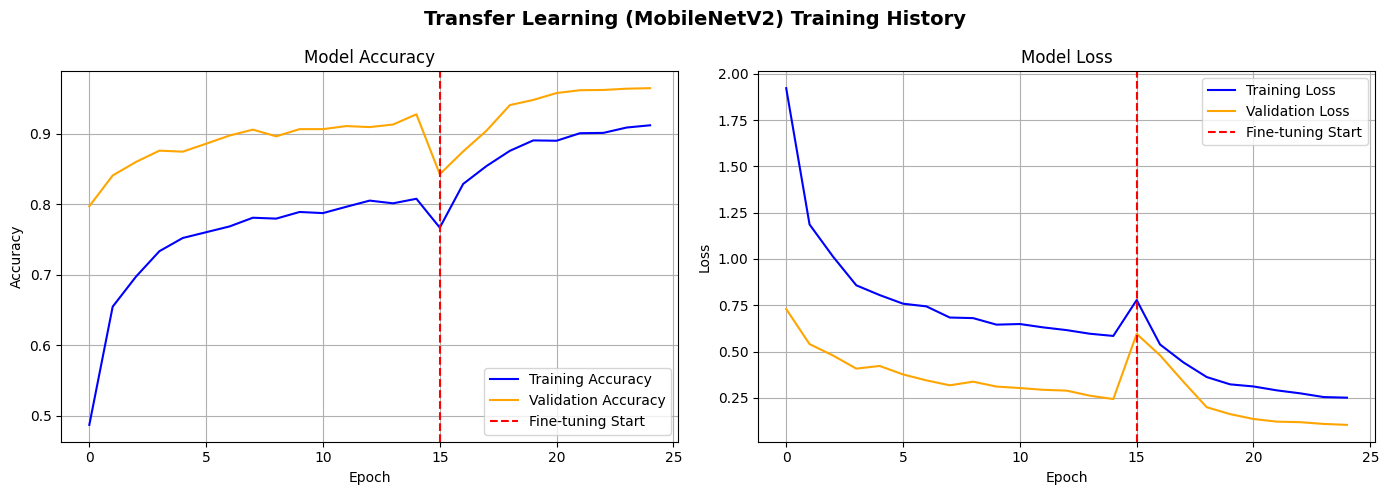

In [35]:
# =============================================================================
# EVALUATE TRANSFER LEARNING MODEL
# =============================================================================

print("=" * 60)
print("📊 EVALUATING TRANSFER LEARNING MODEL")
print("=" * 60)

# Evaluate on test set
test_generator.reset()
test_loss, test_accuracy = transfer_model.evaluate(test_generator, verbose=1)

# Get predictions
test_generator.reset()
predictions = transfer_model.predict(test_generator, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names))

# Overall Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 60)
print("OVERALL METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combine histories
all_acc = history_transfer.history['accuracy'] + history_fine_tune.history['accuracy']
all_val_acc = history_transfer.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
all_loss = history_transfer.history['loss'] + history_fine_tune.history['loss']
all_val_loss = history_transfer.history['val_loss'] + history_fine_tune.history['val_loss']

# Accuracy plot
axes[0].plot(all_acc, label='Training Accuracy', color='blue')
axes[0].plot(all_val_acc, label='Validation Accuracy', color='orange')
axes[0].axvline(x=len(history_transfer.history['accuracy']), color='red', linestyle='--', label='Fine-tuning Start')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(all_loss, label='Training Loss', color='blue')
axes[1].plot(all_val_loss, label='Validation Loss', color='orange')
axes[1].axvline(x=len(history_transfer.history['loss']), color='red', linestyle='--', label='Fine-tuning Start')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Transfer Learning (MobileNetV2) Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
# Plot training history
def plot_training_history(history, title="Training History"):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal Training Metrics:")
    print(f"  Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"  Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"  Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Plot CNN training history (only if CNN was trained)
if 'history_cnn' in dir():
    plot_training_history(history_cnn, "CNN Model (From Scratch) - Training History")
else:
    print("⚠️ CNN training was skipped - using Transfer Learning instead.")
    print("✅ Transfer Learning results are available above.")

⚠️ CNN training was skipped - using Transfer Learning instead.
✅ Transfer Learning results are available above.


## 9. Model Evaluation

Now we will evaluate our trained CNN model on the test set using various metrics:

### Evaluation Metrics:
- **Accuracy**: Overall correct predictions / total predictions
- **Precision**: True Positives / (True Positives + False Positives)
  - How many of the predicted positives are actually positive
- **Recall**: True Positives / (True Positives + False Negatives)
  - How many actual positives were correctly identified
- **F1-Score**: Harmonic mean of Precision and Recall
  - Balanced measure considering both precision and recall

### Confusion Matrix:
Visual representation of true vs predicted labels for each class.

Evaluating CNN Model on Test Set...
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step

CNN Model (From Scratch) - Evaluation Results

Overall Metrics:
  Accuracy:  0.0210 (2.10%)
  Precision: 0.0166
  Recall:    0.0210
  F1-Score:  0.0041

Detailed Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

               Bangus     0.0000    0.0000    0.0000        34
        Big Head Carp     0.0000    0.0000    0.0000        43
   Black Spotted Barb     0.0000    0.0000    0.0000        40
              Catfish     0.0000    0.0000    0.0000        62
       Climbing Perch     0.0161    0.0333    0.0217        30
 Fourfinger Threadfin     0.0000    0.0000    0.0000        38
       Freshwater Eel     0.0000    0.0000    0.0000        55
       Glass Perchlet     0.0000    0.0000    0.0000        77
                 Goby     0.0000    0.0000    0.0000       124
            Gold Fish     0.6667    0.0488    0

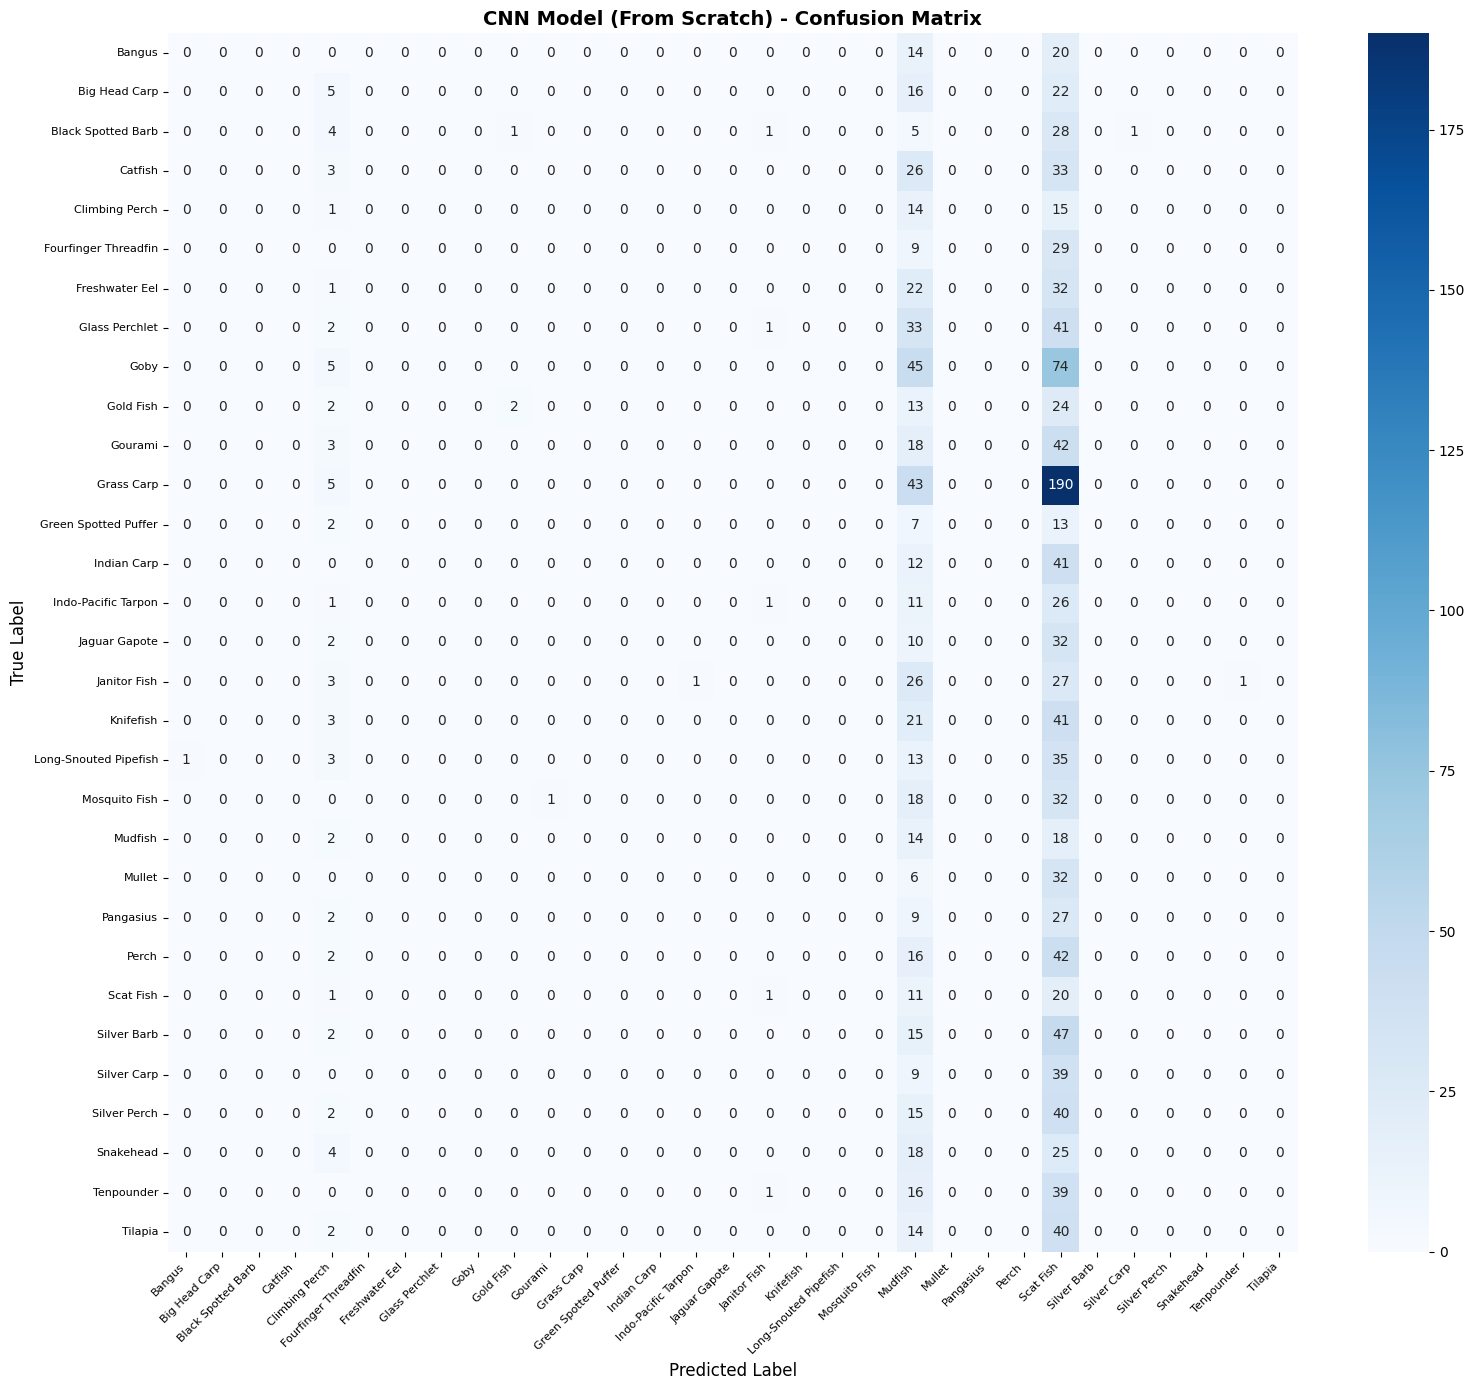

In [38]:
def evaluate_model(model, test_generator, class_names, model_name="Model"):
    """
    Comprehensive model evaluation with metrics and visualizations
    """
    # Reset generator
    test_generator.reset()
    
    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Results")
    print(f"{'='*60}")
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print("-" * 60)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred,
        'y_true': y_true,
        'predictions': predictions
    }

# Evaluate CNN model
print("Evaluating CNN Model on Test Set...")
cnn_results = evaluate_model(cnn_model, test_generator, class_names, "CNN Model (From Scratch)")

## 10. Transfer Learning with Pre-trained CNN

Transfer learning leverages knowledge from models pre-trained on large datasets (like ImageNet) to improve performance on our specific task. We will use **MobileNetV2** because:

### Why MobileNetV2?
1. **Efficient Architecture**: Optimized for mobile and edge devices
2. **Strong Performance**: Competitive accuracy with fewer parameters
3. **Pre-trained on ImageNet**: 1000+ classes, diverse features learned
4. **Fast Training**: Fewer parameters to fine-tune

### Transfer Learning Strategy:
1. **Load pre-trained MobileNetV2** (without top classification layers)
2. **Freeze base layers** to preserve learned features
3. **Add custom classification head** for our 31 fish classes
4. **Train only the new layers** initially

In [39]:
def build_transfer_learning_model(input_shape, num_classes):
    """
    Build a transfer learning model using MobileNetV2 as base
    """
    # Load pre-trained MobileNetV2 (without top layers)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Build transfer learning model
print("Building Transfer Learning Model with MobileNetV2...")
transfer_model, base_model = build_transfer_learning_model(INPUT_SHAPE, num_classes)

# Display model summary
print("\nTransfer Learning Model Architecture")
print("=" * 60)
transfer_model.summary()

print(f"\nModel Statistics:")
print(f"  Total parameters: {transfer_model.count_params():,}")
print(f"  Base model parameters (frozen): {base_model.count_params():,}")
print(f"  Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights]):,}")

Building Transfer Learning Model with MobileNetV2...

Transfer Learning Model Architecture


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,061,343 (11.68 MB)

 Trainable params: 799,263 (3.05 MB)

 Non-trainable params: 2,262,080 (8.63 MB)


Model Statistics:
  Total parameters: 3,061,343
  Base model parameters (frozen): 2,257,984
  Trainable parameters: 799,263


In [40]:
# Compile transfer learning model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for transfer learning
transfer_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_transfer_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Transfer learning model compiled!")

# Train transfer learning model (Phase 1: Frozen base)
print("\nPhase 1: Training with Frozen Base Model...")
print("=" * 60)

history_transfer = transfer_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=transfer_callbacks,
    verbose=1
)

print("\nPhase 1 Training completed!")

Transfer learning model compiled!

Phase 1: Training with Frozen Base Model...
Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.3379 - loss: 2.5103
Epoch 1: val_accuracy improved from None to 0.76481, saving model to best_transfer_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.4717 - loss: 1.9021 - val_accuracy: 0.7648 - val_loss: 0.7856 - learning_rate: 0.0010
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.6390 - loss: 1.2012
Epoch 2: val_accuracy improved from 0.76481 to 0.79862, saving model to best_transfer_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 275s 995ms/step - accuracy: 0.6546 - loss: 1.1617 - val_accuracy: 0.7986 - val_loss: 0.6398 - learning_rate: 0.0010
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.6848 - loss: 1.0141
Epoch 3: val_accuracy improved from 0.79862 to 0.85496, saving model to best_transfer_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 275s 998ms/step - accuracy: 0.7028 - loss: 0.9746 

In [41]:
# Fine-tuning: Unfreeze some top layers of base model
print("\nPhase 2: Fine-tuning (Unfreezing top layers)...")
print("=" * 60)

# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine_tune = transfer_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=transfer_callbacks,
    verbose=1
)

print("\nFine-tuning completed!")


Phase 2: Fine-tuning (Unfreezing top layers)...
Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7752 - loss: 0.7151
Epoch 1: val_accuracy did not improve from 0.94475
276/276 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.7967 - loss: 0.6448 - val_accuracy: 0.8710 - val_loss: 0.4408 - learning_rate: 1.0000e-04
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8695 - loss: 0.3944
Epoch 2: val_accuracy did not improve from 0.94475
276/276 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8657 - loss: 0.3975 - val_accuracy: 0.8877 - val_loss: 0.3749 - learning_rate: 1.0000e-04
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8822 - loss: 0.3619
Epoch 3: val_accuracy did not improve from 0.94475
276/276 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.8830 - loss: 0.3541 - val_accuracy: 0.9386 - val_loss: 0.2031 - learning_rate: 1.0000e-04
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8987 - loss: 0.2835
Epoch 4: val_accurac

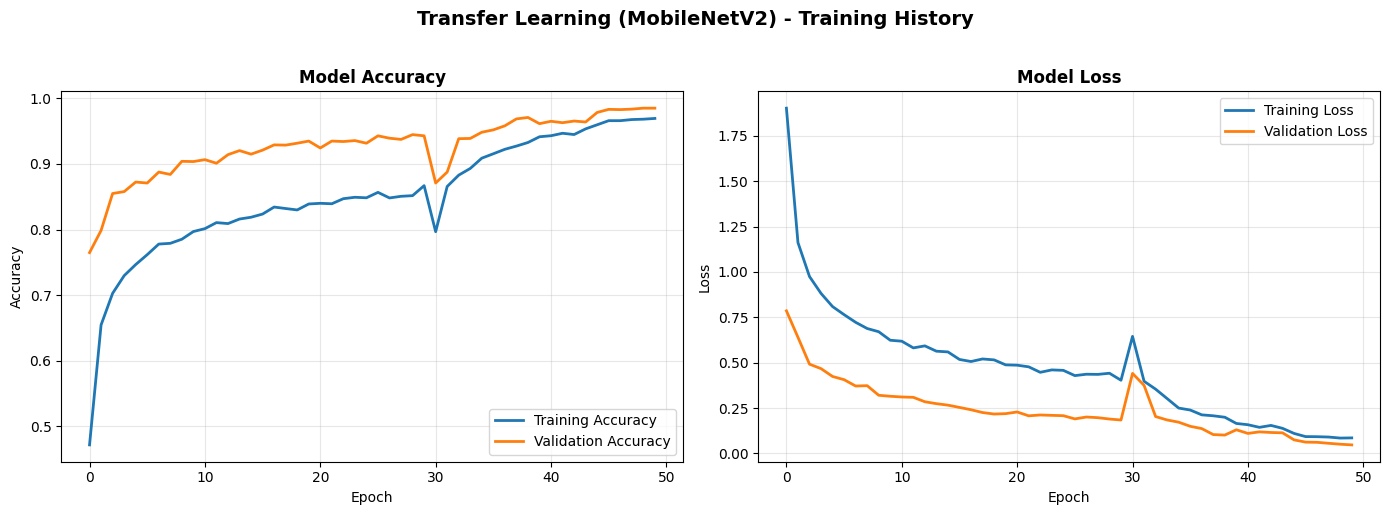


Final Training Metrics:
  Training Accuracy: 0.9694
  Validation Accuracy: 0.9851
  Training Loss: 0.0855
  Validation Loss: 0.0470


In [42]:
# Plot transfer learning training history
# Combine histories
def combine_histories(history1, history2):
    """Combine two training histories"""
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key]
    return type('obj', (object,), {'history': combined})()

combined_history = combine_histories(history_transfer, history_fine_tune)
plot_training_history(combined_history, "Transfer Learning (MobileNetV2) - Training History")

Evaluating Transfer Learning Model on Test Set...
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 508ms/step

Transfer Learning (MobileNetV2) - Evaluation Results

Overall Metrics:
  Accuracy:  0.9790 (97.90%)
  Precision: 0.9796
  Recall:    0.9790
  F1-Score:  0.9790

Detailed Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

               Bangus     0.8718    1.0000    0.9315        34
        Big Head Carp     0.9773    1.0000    0.9885        43
   Black Spotted Barb     1.0000    0.9500    0.9744        40
              Catfish     0.9677    0.9677    0.9677        62
       Climbing Perch     0.9355    0.9667    0.9508        30
 Fourfinger Threadfin     1.0000    0.9737    0.9867        38
       Freshwater Eel     0.9643    0.9818    0.9730        55
       Glass Perchlet     0.9872    1.0000    0.9935        77
                 Goby     0.9839    0.9839    0.9839       124
            Gold Fish 

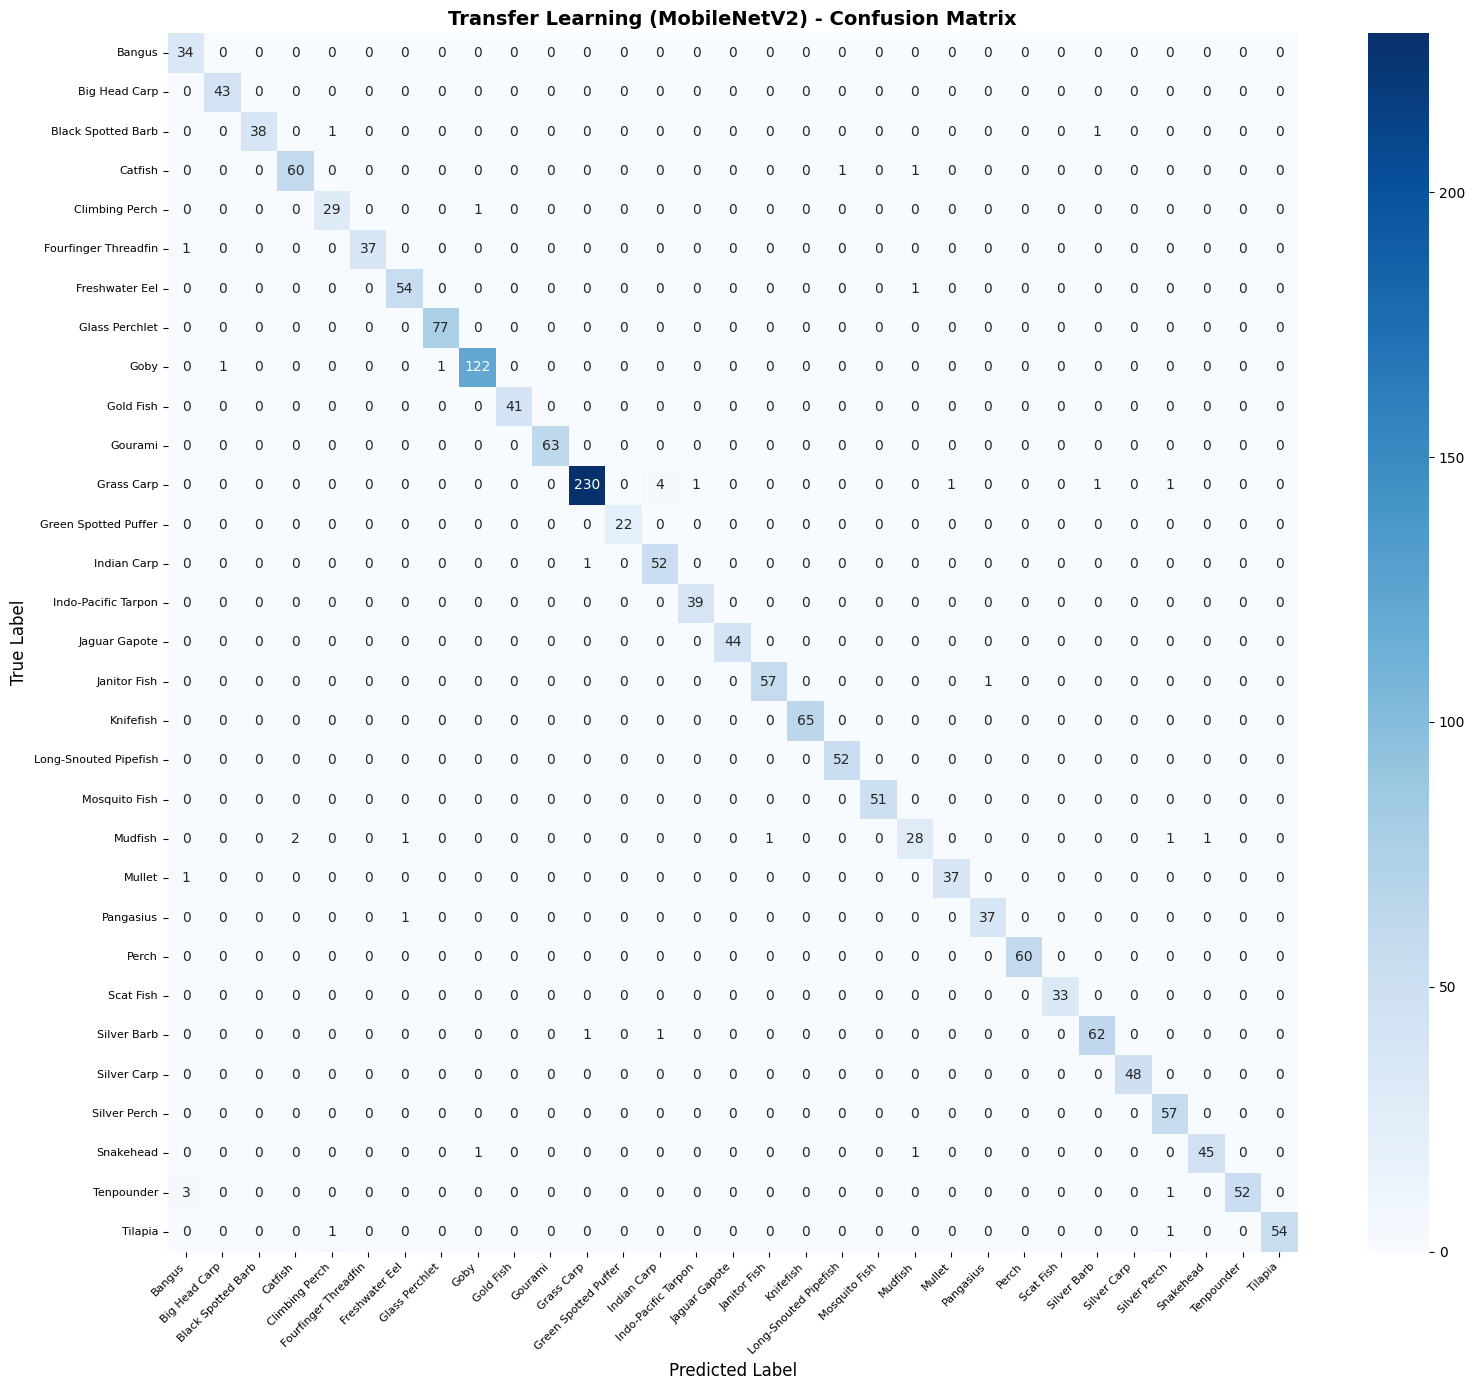

In [43]:
# Evaluate transfer learning model
print("Evaluating Transfer Learning Model on Test Set...")
transfer_results = evaluate_model(transfer_model, test_generator, class_names, "Transfer Learning (MobileNetV2)")

## 11. Model Comparison


In [44]:
# Create comparison table
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Total Parameters'],
    'CNN from Scratch': [
        f"{cnn_results['accuracy']:.4f}",
        f"{cnn_results['precision']:.4f}",
        f"{cnn_results['recall']:.4f}",
        f"{cnn_results['f1_score']:.4f}",
        f"{cnn_model.count_params():,}"
    ],
    'Transfer Learning (MobileNetV2)': [
        f"{transfer_results['accuracy']:.4f}",
        f"{transfer_results['precision']:.4f}",
        f"{transfer_results['recall']:.4f}",
        f"{transfer_results['f1_score']:.4f}",
        f"{transfer_model.count_params():,}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("=" * 70)
print("MODEL COMPARISON - Performance Summary")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

# Determine the better model
cnn_f1 = cnn_results['f1_score']
transfer_f1 = transfer_results['f1_score']

if transfer_f1 > cnn_f1:
    winner = "Transfer Learning (MobileNetV2)"
    improvement = ((transfer_f1 - cnn_f1) / cnn_f1) * 100
else:
    winner = "CNN from Scratch"
    improvement = ((cnn_f1 - transfer_f1) / transfer_f1) * 100

print(f"\nBest Performing Model: {winner}")
print(f"   Performance improvement: {improvement:.2f}%")

MODEL COMPARISON - Performance Summary
          Metric CNN from Scratch Transfer Learning (MobileNetV2)
        Accuracy           0.0210                          0.9790
       Precision           0.0166                          0.9796
          Recall           0.0210                          0.9790
        F1-Score           0.0041                          0.9790
Total Parameters       27,009,087                       3,061,343

Best Performing Model: Transfer Learning (MobileNetV2)
   Performance improvement: 23824.22%


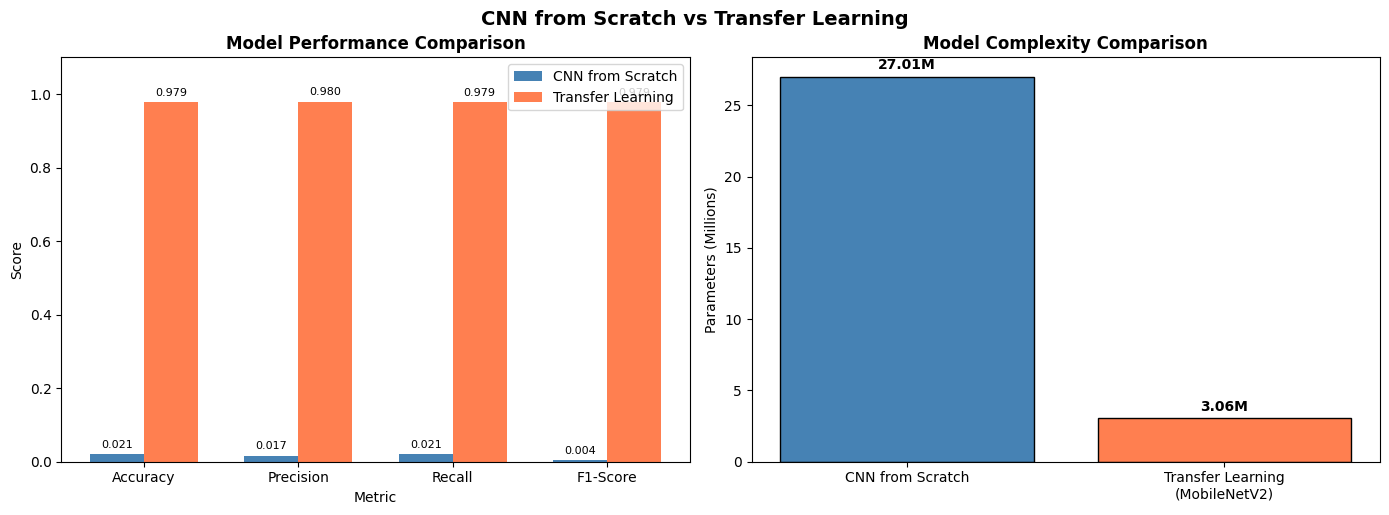

In [45]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cnn_values = [cnn_results['accuracy'], cnn_results['precision'], 
              cnn_results['recall'], cnn_results['f1_score']]
transfer_values = [transfer_results['accuracy'], transfer_results['precision'], 
                   transfer_results['recall'], transfer_results['f1_score']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, cnn_values, width, label='CNN from Scratch', color='steelblue')
bars2 = axes[0].bar(x + width/2, transfer_values, width, label='Transfer Learning', color='coral')

axes[0].set_xlabel('Metric')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)

# Parameter comparison
model_names = ['CNN from Scratch', 'Transfer Learning\n(MobileNetV2)']
params = [cnn_model.count_params() / 1e6, transfer_model.count_params() / 1e6]  # In millions

bars3 = axes[1].bar(model_names, params, color=['steelblue', 'coral'], edgecolor='black')
axes[1].set_ylabel('Parameters (Millions)')
axes[1].set_title('Model Complexity Comparison', fontsize=12, fontweight='bold')

for bar, param in zip(bars3, params):
    axes[1].annotate(f'{param:.2f}M',
                     xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('CNN from Scratch vs Transfer Learning', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 12. CNN Interpretation & Visualization


Visualizing Feature Maps from CNN Model...


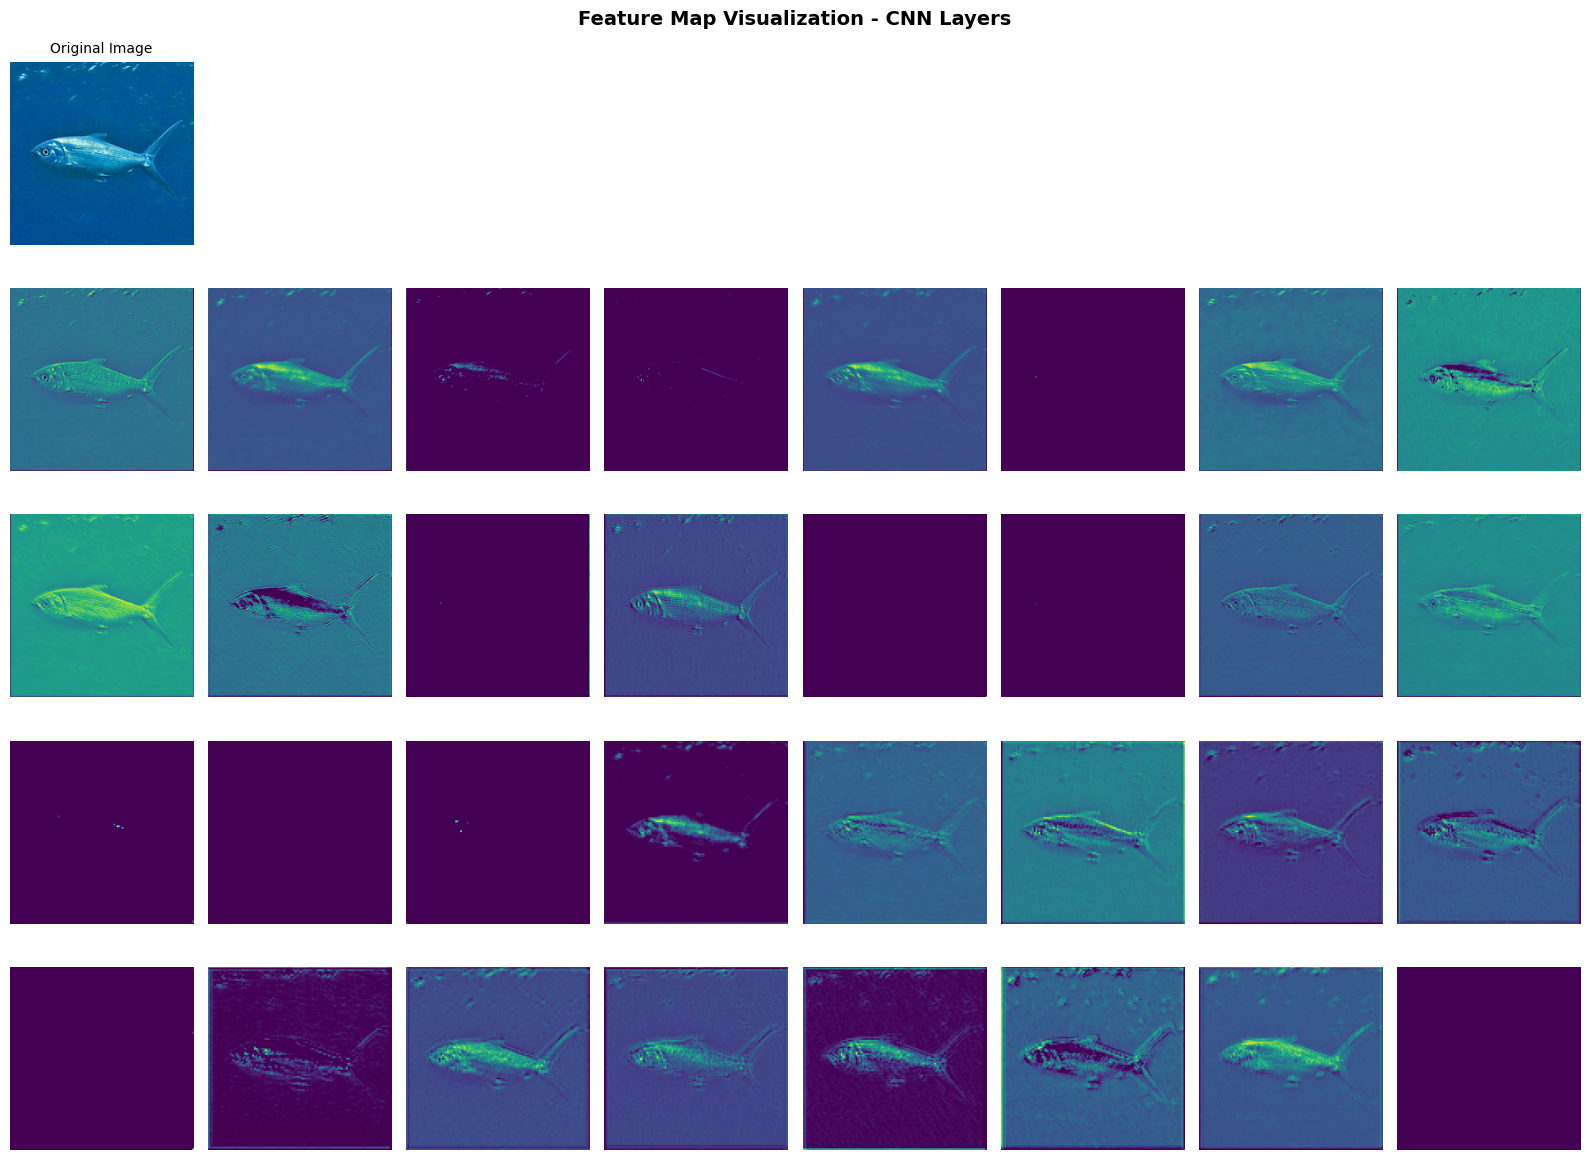

In [46]:
# Feature Map Visualization for CNN from Scratch
def visualize_feature_maps(model, image_path, layer_indices=None):
    """
    Visualize feature maps from specified layers
    """
    # Load and preprocess image
    img = Image.open(image_path)
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Get conv layer indices if not provided
    if layer_indices is None:
        layer_indices = [i for i, layer in enumerate(model.layers) 
                        if 'conv2d' in layer.name][:4]  # First 4 conv layers
    
    # Create a model that outputs feature maps
    layer_outputs = [model.layers[i].output for i in layer_indices if i < len(model.layers)]
    feature_map_model = Model(inputs=model.inputs, outputs=layer_outputs)
    
    # Get feature maps
    feature_maps = feature_map_model.predict(img_array, verbose=0)
    
    # Display original image
    fig = plt.figure(figsize=(16, 12))
    
    # Original image
    plt.subplot(len(layer_indices) + 1, 8, 1)
    plt.imshow(img)
    plt.title('Original Image', fontsize=10)
    plt.axis('off')
    
    # Feature maps for each layer
    for idx, (layer_idx, fmap) in enumerate(zip(layer_indices, feature_maps)):
        layer_name = model.layers[layer_idx].name
        n_features = min(8, fmap.shape[-1])  # Show max 8 features
        
        for i in range(n_features):
            plt.subplot(len(layer_indices) + 1, 8, (idx + 1) * 8 + i + 1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            if i == 0:
                plt.ylabel(f'{layer_name}', fontsize=8)
            plt.axis('off')
    
    plt.suptitle('Feature Map Visualization - CNN Layers', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Get a sample image for visualization
sample_class = class_names[0]
sample_img_path = os.path.join(TRAIN_DIR, sample_class, os.listdir(os.path.join(TRAIN_DIR, sample_class))[0])

print("Visualizing Feature Maps from CNN Model...")
visualize_feature_maps(cnn_model, sample_img_path)

CNN Model (From Scratch) - Sample Predictions:


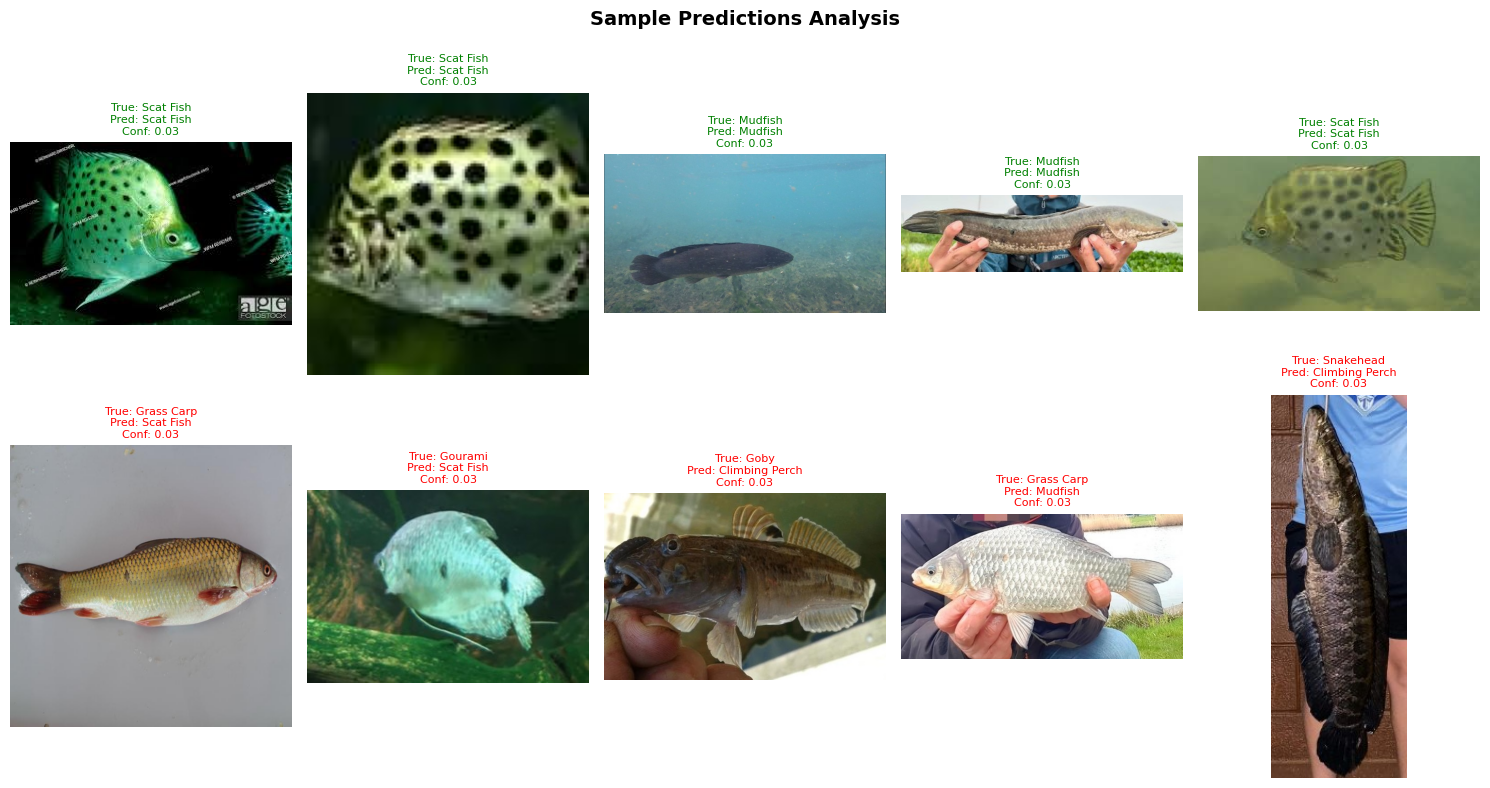


Transfer Learning Model - Sample Predictions:


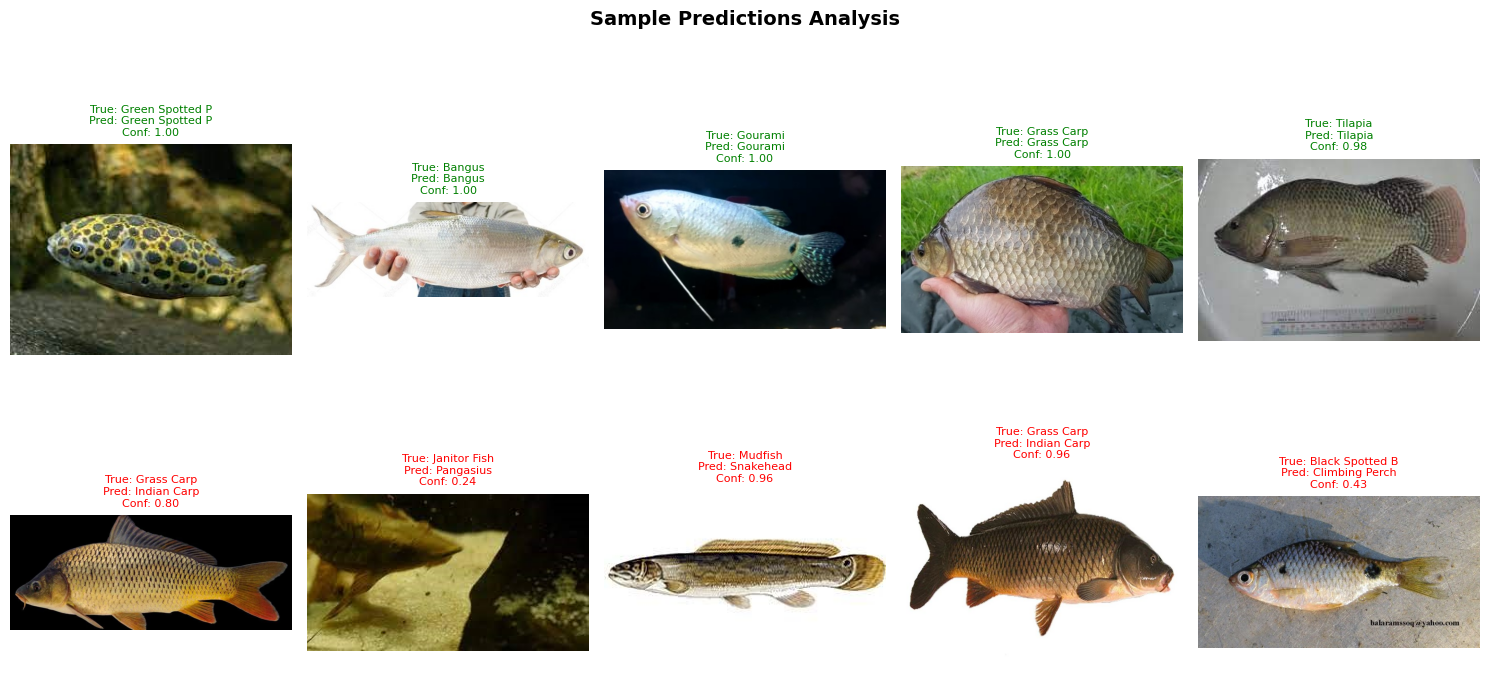

In [47]:
# Visualize correct and incorrect predictions
def visualize_predictions(model, test_generator, class_names, n_samples=5):
    """
    Visualize correct and incorrect predictions
    """
    test_generator.reset()
    
    # Get predictions
    predictions = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Get image paths
    filenames = test_generator.filenames
    
    # Find correct and incorrect predictions
    correct_indices = np.where(y_pred == y_true)[0]
    incorrect_indices = np.where(y_pred != y_true)[0]
    
    # Sample from each
    n_correct = min(n_samples, len(correct_indices))
    n_incorrect = min(n_samples, len(incorrect_indices))
    
    correct_samples = np.random.choice(correct_indices, n_correct, replace=False)
    incorrect_samples = np.random.choice(incorrect_indices, n_incorrect, replace=False) if len(incorrect_indices) > 0 else []
    
    # Plot correct predictions
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
    
    # Correct predictions
    for i, idx in enumerate(correct_samples):
        img_path = os.path.join(TEST_DIR, filenames[idx])
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        conf = predictions[idx][y_pred[idx]]
        axes[0, i].set_title(f'True: {true_label[:15]}\nPred: {pred_label[:15]}\nConf: {conf:.2f}', 
                            fontsize=8, color='green')
        axes[0, i].axis('off')
    
    axes[0, 0].set_ylabel('Correct', fontsize=12, fontweight='bold')
    
    # Incorrect predictions
    if len(incorrect_samples) > 0:
        for i, idx in enumerate(incorrect_samples):
            img_path = os.path.join(TEST_DIR, filenames[idx])
            img = Image.open(img_path)
            axes[1, i].imshow(img)
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            conf = predictions[idx][y_pred[idx]]
            axes[1, i].set_title(f'True: {true_label[:15]}\nPred: {pred_label[:15]}\nConf: {conf:.2f}', 
                                fontsize=8, color='red')
            axes[1, i].axis('off')
        
        axes[1, 0].set_ylabel('Incorrect', fontsize=12, fontweight='bold')
    else:
        for i in range(n_samples):
            axes[1, i].text(0.5, 0.5, 'No incorrect\npredictions!', 
                          ha='center', va='center', fontsize=12)
            axes[1, i].axis('off')
    
    plt.suptitle('Sample Predictions Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions for both models
print("CNN Model (From Scratch) - Sample Predictions:")
visualize_predictions(cnn_model, test_generator, class_names)

print("\nTransfer Learning Model - Sample Predictions:")
visualize_predictions(transfer_model, test_generator, class_names)

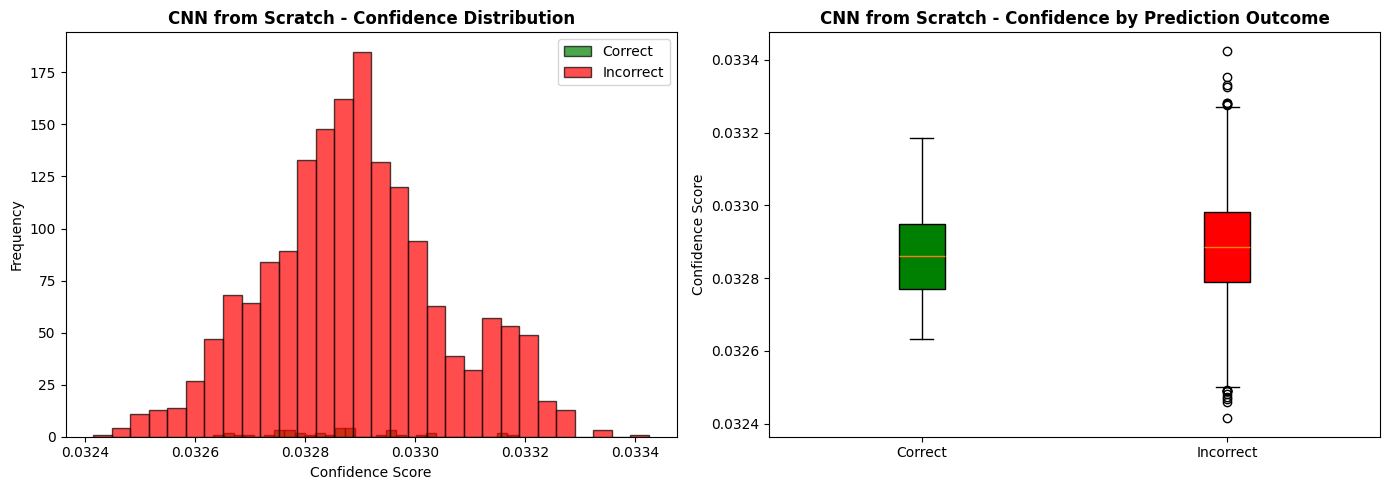


CNN from Scratch Confidence Statistics:
  Correct predictions - Mean: 0.0329, Std: 0.0001
  Incorrect predictions - Mean: 0.0329, Std: 0.0002


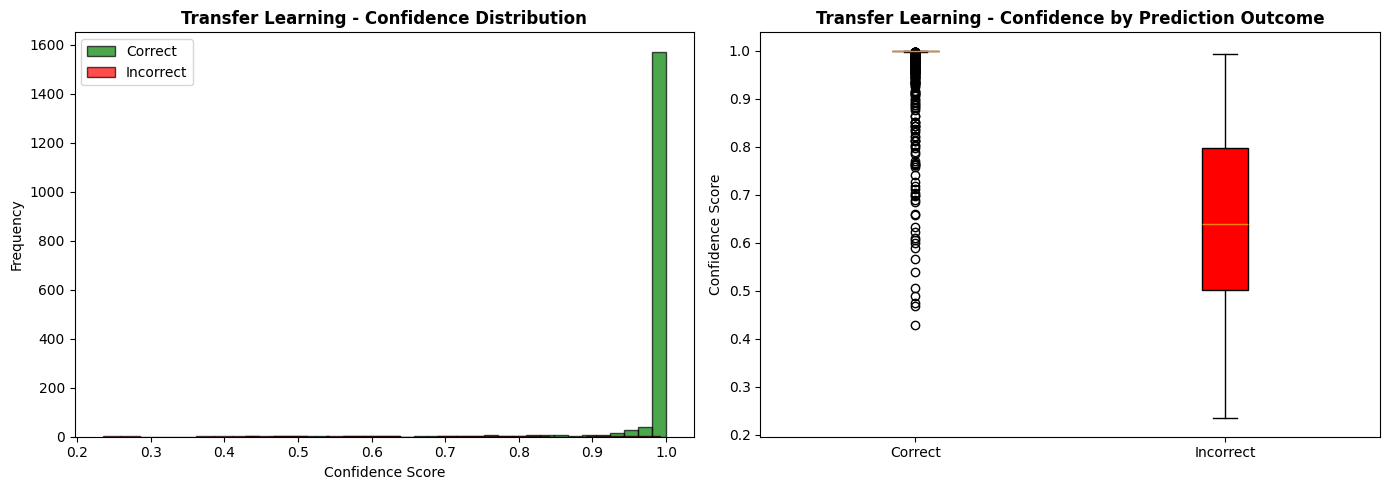


Transfer Learning Confidence Statistics:
  Correct predictions - Mean: 0.9878, Std: 0.0526
  Incorrect predictions - Mean: 0.6496, Std: 0.2105


In [48]:
# Visualize prediction confidence distribution
def plot_confidence_distribution(predictions, y_true, y_pred, title="Model"):
    """
    Plot the distribution of prediction confidences for correct vs incorrect predictions
    """
    # Get confidence scores
    confidences = np.max(predictions, axis=1)
    
    correct_mask = y_pred == y_true
    correct_confidences = confidences[correct_mask]
    incorrect_confidences = confidences[~correct_mask]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of confidences
    axes[0].hist(correct_confidences, bins=30, alpha=0.7, label='Correct', color='green', edgecolor='black')
    axes[0].hist(incorrect_confidences, bins=30, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
    axes[0].set_xlabel('Confidence Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{title} - Confidence Distribution', fontweight='bold')
    axes[0].legend()
    
    # Box plot comparison
    data = [correct_confidences, incorrect_confidences]
    bp = axes[1].boxplot(data, labels=['Correct', 'Incorrect'], patch_artist=True)
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][1].set_facecolor('red')
    axes[1].set_ylabel('Confidence Score')
    axes[1].set_title(f'{title} - Confidence by Prediction Outcome', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title} Confidence Statistics:")
    print(f"  Correct predictions - Mean: {np.mean(correct_confidences):.4f}, Std: {np.std(correct_confidences):.4f}")
    if len(incorrect_confidences) > 0:
        print(f"  Incorrect predictions - Mean: {np.mean(incorrect_confidences):.4f}, Std: {np.std(incorrect_confidences):.4f}")

# Plot confidence distributions
plot_confidence_distribution(cnn_results['predictions'], cnn_results['y_true'], 
                            cnn_results['y_pred'], "CNN from Scratch")

plot_confidence_distribution(transfer_results['predictions'], transfer_results['y_true'], 
                            transfer_results['y_pred'], "Transfer Learning")

Analyzing Per-Class Performance...


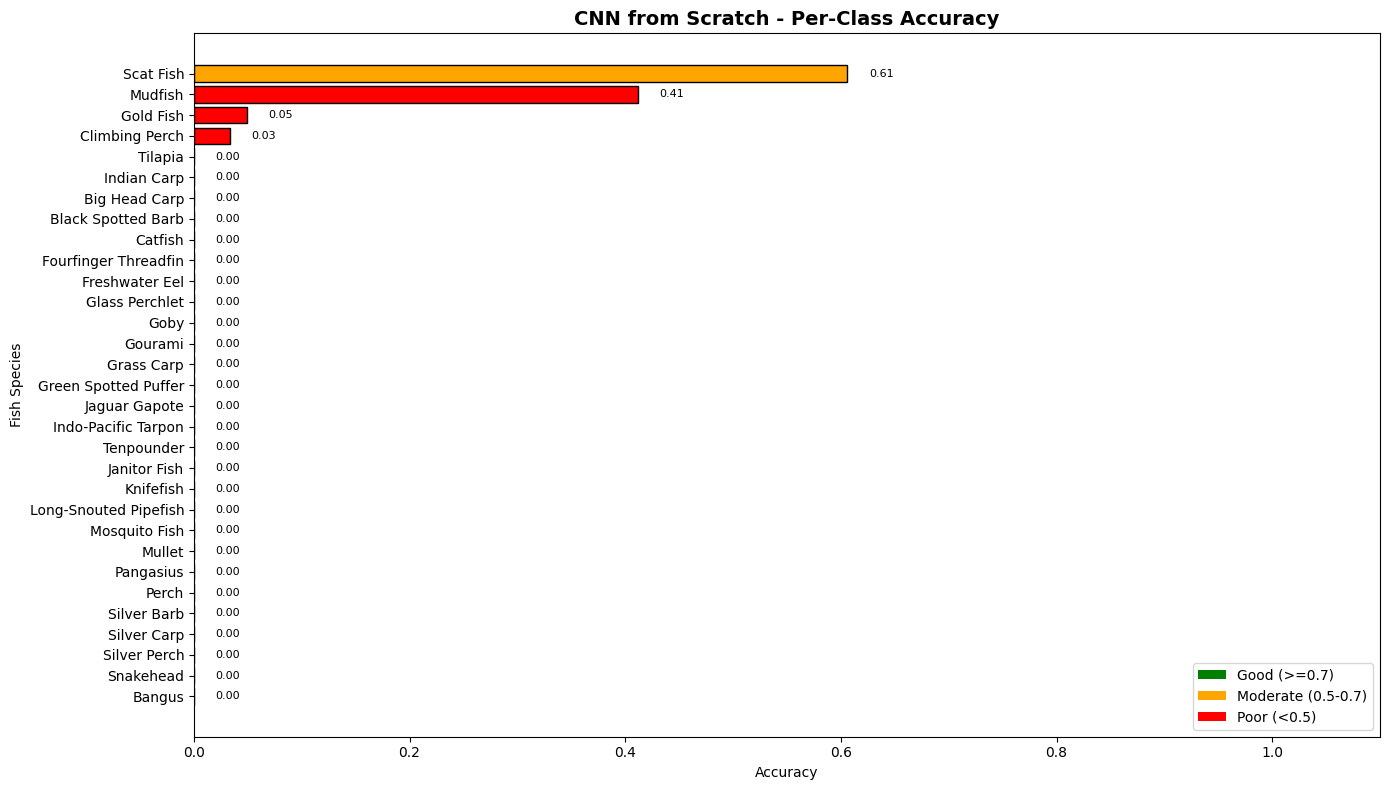


CNN from Scratch - Challenging Classes (Accuracy < 0.7):
  - Bangus: 0.00
  - Snakehead: 0.00
  - Silver Perch: 0.00
  - Silver Carp: 0.00
  - Silver Barb: 0.00
  - Perch: 0.00
  - Pangasius: 0.00
  - Mullet: 0.00
  - Mosquito Fish: 0.00
  - Long-Snouted Pipefish: 0.00
  - Knifefish: 0.00
  - Janitor Fish: 0.00
  - Tenpounder: 0.00
  - Indo-Pacific Tarpon: 0.00
  - Jaguar Gapote: 0.00
  - Green Spotted Puffer: 0.00
  - Grass Carp: 0.00
  - Gourami: 0.00
  - Goby: 0.00
  - Glass Perchlet: 0.00
  - Freshwater Eel: 0.00
  - Fourfinger Threadfin: 0.00
  - Catfish: 0.00
  - Black Spotted Barb: 0.00
  - Big Head Carp: 0.00
  - Indian Carp: 0.00
  - Tilapia: 0.00
  - Climbing Perch: 0.03
  - Gold Fish: 0.05
  - Mudfish: 0.41
  - Scat Fish: 0.61


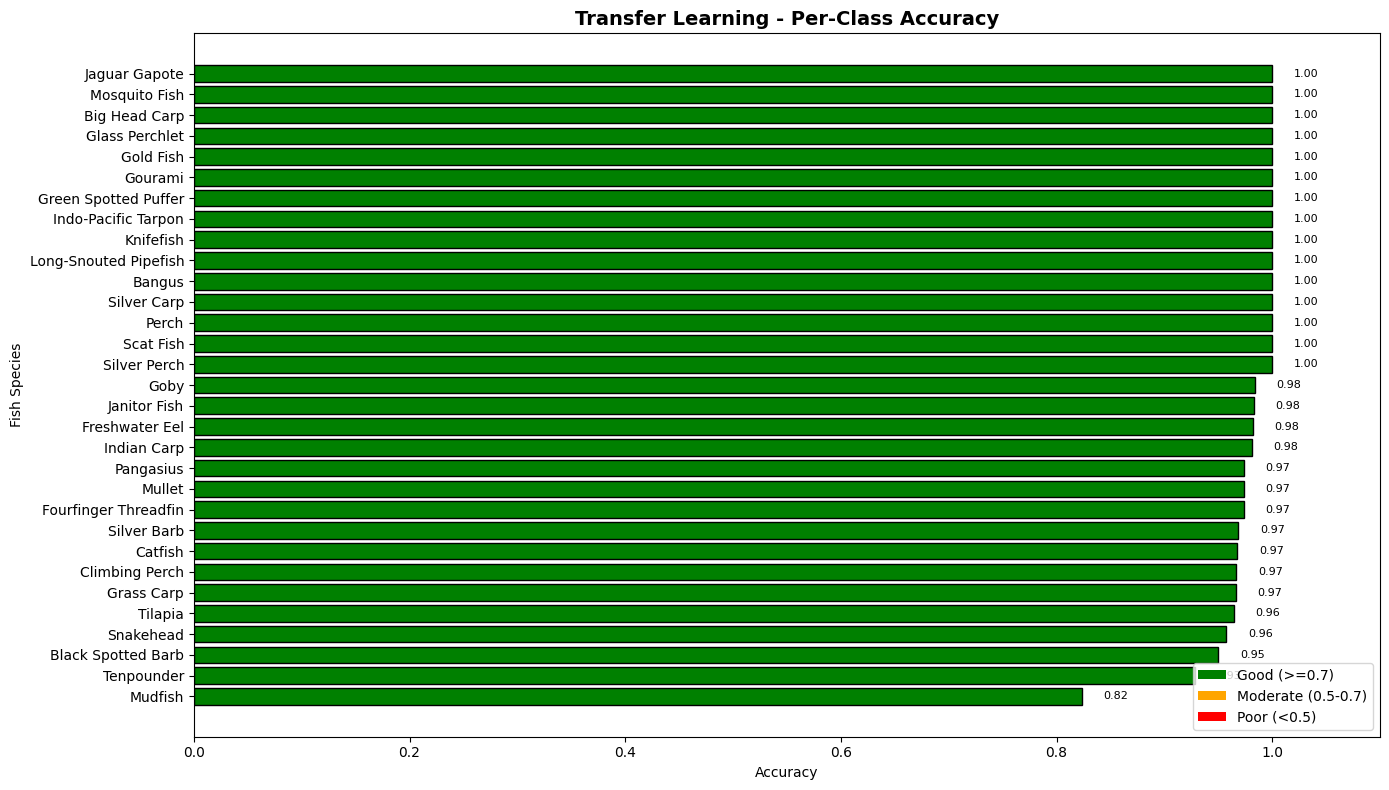


Transfer Learning - Challenging Classes (Accuracy < 0.7):


In [49]:
# Per-class accuracy analysis
def plot_per_class_accuracy(y_true, y_pred, class_names, title="Model"):
    """
    Plot per-class accuracy to identify which classes are harder to classify
    """
    # Calculate per-class accuracy
    class_accuracies = []
    for i in range(len(class_names)):
        mask = y_true == i
        if mask.sum() > 0:
            acc = (y_pred[mask] == i).sum() / mask.sum()
        else:
            acc = 0
        class_accuracies.append(acc)
    
    # Sort by accuracy
    sorted_indices = np.argsort(class_accuracies)
    sorted_names = [class_names[i] for i in sorted_indices]
    sorted_accs = [class_accuracies[i] for i in sorted_indices]
    
    # Color based on accuracy
    colors = ['red' if acc < 0.5 else 'orange' if acc < 0.7 else 'green' for acc in sorted_accs]
    
    plt.figure(figsize=(14, 8))
    bars = plt.barh(sorted_names, sorted_accs, color=colors, edgecolor='black')
    plt.xlabel('Accuracy')
    plt.ylabel('Fish Species')
    plt.title(f'{title} - Per-Class Accuracy', fontsize=14, fontweight='bold')
    plt.xlim(0, 1.1)
    
    # Add value labels
    for bar, acc in zip(bars, sorted_accs):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{acc:.2f}', va='center', fontsize=8)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='green', label='Good (>=0.7)'),
                      Patch(facecolor='orange', label='Moderate (0.5-0.7)'),
                      Patch(facecolor='red', label='Poor (<0.5)')]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Print worst performing classes
    print(f"\n{title} - Challenging Classes (Accuracy < 0.7):")
    for name, acc in zip(sorted_names, sorted_accs):
        if acc < 0.7:
            print(f"  - {name}: {acc:.2f}")

# Analyze per-class accuracy
print("Analyzing Per-Class Performance...")
plot_per_class_accuracy(cnn_results['y_true'], cnn_results['y_pred'], 
                        class_names, "CNN from Scratch")
plot_per_class_accuracy(transfer_results['y_true'], transfer_results['y_pred'], 
                        class_names, "Transfer Learning")

In [50]:
# Final Summary Statistics
print("=" * 70)
print("FINAL PROJECT SUMMARY")
print("=" * 70)

print(f"\nDataset Information:")
print(f"   - Number of Fish Species: {num_classes}")
print(f"   - Training Images: {train_generator.samples}")
print(f"   - Validation Images: {val_generator.samples}")
print(f"   - Test Images: {test_generator.samples}")

print(f"\nModel Performance on Test Set:")
print(f"\n   CNN from Scratch:")
print(f"   - Accuracy:  {cnn_results['accuracy']*100:.2f}%")
print(f"   - F1-Score:  {cnn_results['f1_score']:.4f}")

print(f"\n   Transfer Learning (MobileNetV2):")
print(f"   - Accuracy:  {transfer_results['accuracy']*100:.2f}%")
print(f"   - F1-Score:  {transfer_results['f1_score']:.4f}")

# Determine winner
if transfer_results['f1_score'] > cnn_results['f1_score']:
    best_model = "Transfer Learning (MobileNetV2)"
    best_accuracy = transfer_results['accuracy']
    best_f1 = transfer_results['f1_score']
else:
    best_model = "CNN from Scratch"
    best_accuracy = cnn_results['accuracy']
    best_f1 = cnn_results['f1_score']

print(f"\nBest Model: {best_model}")
print(f"   - Final Accuracy: {best_accuracy*100:.2f}%")
print(f"   - Final F1-Score: {best_f1:.4f}")

print("\n" + "=" * 70)
print("Project completed successfully!")
print("=" * 70)

FINAL PROJECT SUMMARY

Dataset Information:
   - Number of Fish Species: 31
   - Training Images: 8801
   - Validation Images: 2751
   - Test Images: 1760

Model Performance on Test Set:

   CNN from Scratch:
   - Accuracy:  2.10%
   - F1-Score:  0.0041

   Transfer Learning (MobileNetV2):
   - Accuracy:  97.90%
   - F1-Score:  0.9790

Best Model: Transfer Learning (MobileNetV2)
   - Final Accuracy: 97.90%
   - Final F1-Score: 0.9790

Project completed successfully!
